In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from Cell_3d import Cell as GridCell
from BookKeepers_3d import Bookkeeper
from Efficient_Resource_Manager_3d import ResourceManager
import pandas as pd
import copy

def save_step_summaries(sim, csv_path):
    """
    Save step summaries for each step in a trial to a CSV file.

    Parameters:
      sim     : a simulate instance after the trial has run.
      csv_path: path to the output CSV file.
    """
    # Extract step summaries from the Bookkeeper
    step_summaries = sim.bookkeeper.step_summaries

    # Create a DataFrame from the step summaries
    df = pd.DataFrame(step_summaries)

    # Save the DataFrame to a CSV file
    df.to_csv(csv_path, index=False, sep=';', decimal=',')

def save_aggregated_trial_data(trial_data, csv_path):
    """
    Save data for each trial and aggregated data for all trials combined to a CSV file.
    Each trial will be a column, followed by an aggregated column. Metrics will be rows.

    Parameters:
      trial_data: list of simulate instances for all trials.
      csv_path  : path to the output CSV file.
    """
    
    metric_keys_ordered = [
        "mean_reproduction",
        "mean_alive_time_good",
        "mean_alive_time_bad",
        "total_alive_time_good",
        "total_alive_time_bad",
        "total_death_counts_good_age",
        "total_death_counts_good_antibiotics",
        "total_death_counts_good_food",
        "total_death_counts_bad_age",
        "total_death_counts_bad_antibiotics",
        "total_death_counts_bad_food",
        "total_death_counts_good", # New metric
        "total_death_counts_bad"   # New metric
    ]

    def calculate_metrics_for_sim(sim_instance):
        metrics = {}
        repro_records_list = list(sim_instance.bookkeeper.reproduction_records.values())
        alive_good_list = sim_instance.bookkeeper.alive_times['good']
        alive_bad_list = sim_instance.bookkeeper.alive_times['bad']

        metrics["mean_reproduction"] = np.mean(repro_records_list) if repro_records_list else np.nan
        metrics["mean_alive_time_good"] = np.mean(alive_good_list) if alive_good_list else np.nan
        metrics["mean_alive_time_bad"] = np.mean(alive_bad_list) if alive_bad_list else np.nan
        
        metrics["total_alive_time_good"] = sum(alive_good_list)
        metrics["total_alive_time_bad"] = sum(alive_bad_list)

        metrics["total_death_counts_good_age"] = sim_instance.bookkeeper.death_counts['good']['age']
        metrics["total_death_counts_good_antibiotics"] = sim_instance.bookkeeper.death_counts['good']['antibiotics']
        metrics["total_death_counts_good_food"] = sim_instance.bookkeeper.death_counts['good']['food']
        metrics["total_death_counts_bad_age"] = sim_instance.bookkeeper.death_counts['bad']['age']
        metrics["total_death_counts_bad_antibiotics"] = sim_instance.bookkeeper.death_counts['bad']['antibiotics']
        metrics["total_death_counts_bad_food"] = sim_instance.bookkeeper.death_counts['bad']['food']
        
        # Calculate total deaths for good cells
        metrics["total_death_counts_good"] = (
            sim_instance.bookkeeper.death_counts['good']['age'] +
            sim_instance.bookkeeper.death_counts['good']['antibiotics'] +
            sim_instance.bookkeeper.death_counts['good']['food']
        )
        # Calculate total deaths for bad cells
        metrics["total_death_counts_bad"] = (
            sim_instance.bookkeeper.death_counts['bad']['age'] +
            sim_instance.bookkeeper.death_counts['bad']['antibiotics'] +
            sim_instance.bookkeeper.death_counts['bad']['food']
        )
        return metrics

    all_columns_data = {}

    # Accumulators for overall aggregated data
    grand_total_reproduction_records = []
    grand_total_alive_times_good = []
    grand_total_alive_times_bad = []
    grand_total_death_counts = {
        'good': {'age': 0, 'antibiotics': 0, 'food': 0},
        'bad':  {'age': 0, 'antibiotics': 0, 'food': 0}
    }
    
    if not trial_data:
        print("Warning: No trial data provided. CSV will reflect empty/NaN aggregated data.")

    for i, sim in enumerate(trial_data):
        trial_specific_metrics = calculate_metrics_for_sim(sim)
        all_columns_data[f'Trial {i+1}'] = trial_specific_metrics

        # Accumulate for grand totals
        grand_total_reproduction_records.extend(list(sim.bookkeeper.reproduction_records.values()))
        grand_total_alive_times_good.extend(sim.bookkeeper.alive_times['good'])
        grand_total_alive_times_bad.extend(sim.bookkeeper.alive_times['bad'])
        for cell_type in grand_total_death_counts:
            for cause in grand_total_death_counts[cell_type]:
                grand_total_death_counts[cell_type][cause] += sim.bookkeeper.death_counts[cell_type][cause]

    # Calculate overall aggregated metrics
    aggregated_metrics_column = {}
    aggregated_metrics_column["mean_reproduction"] = np.mean(grand_total_reproduction_records) if grand_total_reproduction_records else np.nan
    aggregated_metrics_column["mean_alive_time_good"] = np.mean(grand_total_alive_times_good) if grand_total_alive_times_good else np.nan
    aggregated_metrics_column["mean_alive_time_bad"] = np.mean(grand_total_alive_times_bad) if grand_total_alive_times_bad else np.nan
    
    aggregated_metrics_column["total_alive_time_good"] = sum(grand_total_alive_times_good)
    aggregated_metrics_column["total_alive_time_bad"] = sum(grand_total_alive_times_bad)

    aggregated_metrics_column["total_death_counts_good_age"] = grand_total_death_counts['good']['age']
    aggregated_metrics_column["total_death_counts_good_antibiotics"] = grand_total_death_counts['good']['antibiotics']
    aggregated_metrics_column["total_death_counts_good_food"] = grand_total_death_counts['good']['food']
    aggregated_metrics_column["total_death_counts_bad_age"] = grand_total_death_counts['bad']['age']
    aggregated_metrics_column["total_death_counts_bad_antibiotics"] = grand_total_death_counts['bad']['antibiotics']
    aggregated_metrics_column["total_death_counts_bad_food"] = grand_total_death_counts['bad']['food']
    
    # Calculate aggregated total deaths
    aggregated_metrics_column["total_death_counts_good"] = (
        grand_total_death_counts['good']['age'] +
        grand_total_death_counts['good']['antibiotics'] +
        grand_total_death_counts['good']['food']
    )
    aggregated_metrics_column["total_death_counts_bad"] = (
        grand_total_death_counts['bad']['age'] +
        grand_total_death_counts['bad']['antibiotics'] +
        grand_total_death_counts['bad']['food']
    )
    
    all_columns_data['Aggregated'] = aggregated_metrics_column

    # Create DataFrame
    df = pd.DataFrame(all_columns_data)
    
    # Ensure the order of metrics (rows) and add any missing metric rows with NaN
    df = df.reindex(metric_keys_ordered)

    # Add 'Metric' column from index
    df = df.reset_index()
    df = df.rename(columns={'index': 'Metric'})

    # Save the DataFrame to a CSV file
    df.to_csv(csv_path, index=False, sep=';', decimal=',')

def calculate_metrics_for_sim_timeframe(sim_instance): # Removed start_step, end_step from params
    metrics = {}
    # Define metric_keys_ordered locally, including the new keys
    metric_keys_ordered = [
        "mean_reproduction",
        "mean_alive_time_good",
        "mean_alive_time_bad",
        "total_alive_time_good",
        "total_alive_time_bad",
        "total_death_counts_good_age",
        "total_death_counts_good_antibiotics",
        "total_death_counts_good_food",
        "total_death_counts_bad_age",
        "total_death_counts_bad_antibiotics",
        "total_death_counts_bad_food",
        "total_death_counts_good", 
        "total_death_counts_bad",
        "alive_good_at_timeframe_end", # <<< New metric
        "alive_bad_at_timeframe_end"   # <<< New metric
    ]
    bk_start = sim_instance.bookkeeper_at_timeframe_start
    bk_end = sim_instance.bookkeeper_at_timeframe_end

    if bk_start is None or bk_end is None:
        print(f"Warning: Bookkeeper snapshots for timeframe not available for a trial. Metrics will be NaN.")
        for key in metric_keys_ordered: 
             metrics[key] = np.nan
        return metrics

    # --- Death Counts ---
    metrics["total_death_counts_good_age"] = bk_end.death_counts['good']['age'] - bk_start.death_counts['good']['age']
    metrics["total_death_counts_good_antibiotics"] = bk_end.death_counts['good']['antibiotics'] - bk_start.death_counts['good']['antibiotics']
    metrics["total_death_counts_good_food"] = bk_end.death_counts['good']['food'] - bk_start.death_counts['good']['food']
    metrics["total_death_counts_bad_age"] = bk_end.death_counts['bad']['age'] - bk_start.death_counts['bad']['age']
    metrics["total_death_counts_bad_antibiotics"] = bk_end.death_counts['bad']['antibiotics'] - bk_start.death_counts['bad']['antibiotics']
    metrics["total_death_counts_bad_food"] = bk_end.death_counts['bad']['food'] - bk_start.death_counts['bad']['food']

    metrics["total_death_counts_good"] = (
        metrics["total_death_counts_good_age"] +
        metrics["total_death_counts_good_antibiotics"] +
        metrics["total_death_counts_good_food"]
    )
    metrics["total_death_counts_bad"] = (
        metrics["total_death_counts_bad_age"] +
        metrics["total_death_counts_bad_antibiotics"] +
        metrics["total_death_counts_bad_food"]
    )

    # --- Alive Times (Lifespans of cells that died within the timeframe) ---
    lifespans_good_in_tf = bk_end.alive_times['good'][len(bk_start.alive_times['good']):]
    lifespans_bad_in_tf = bk_end.alive_times['bad'][len(bk_start.alive_times['bad']):]

    metrics["mean_alive_time_good"] = np.mean(lifespans_good_in_tf) if lifespans_good_in_tf else np.nan
    metrics["mean_alive_time_bad"] = np.mean(lifespans_bad_in_tf) if lifespans_bad_in_tf else np.nan
    
    metrics["total_alive_time_good"] = sum(lifespans_good_in_tf)
    metrics["total_alive_time_bad"] = sum(lifespans_bad_in_tf)

    # --- Mean Reproduction (Average children produced IN TIMEFRAME by parents that reproduced IN TIMEFRAME) ---
    children_produced_in_tf_counts = []
    for parent_id, children_at_end in bk_end.reproduction_records.items():
        children_at_start = bk_start.reproduction_records.get(parent_id, 0)
        produced_in_timeframe = children_at_end - children_at_start
        if produced_in_timeframe > 0:
            children_produced_in_tf_counts.append(produced_in_timeframe)
            
    metrics["mean_reproduction"] = np.mean(children_produced_in_tf_counts) if children_produced_in_tf_counts else np.nan
        
    # --- Alive counts at timeframe end ---
    metrics["alive_good_at_timeframe_end"] = np.nan
    metrics["alive_bad_at_timeframe_end"] = np.nan

    if bk_end and bk_end.step_summaries:
        # The bk_end snapshot is taken after record_step_summary for timeframe_end.
        # The last summary in bk_end.step_summaries should be for the timeframe_end step.
        # Find the summary with the largest step number in bk_end.step_summaries.
        latest_summary_in_bk_end = None
        if bk_end.step_summaries: # Ensure list is not empty
            latest_summary_in_bk_end = max(bk_end.step_summaries, key=lambda s: s['step'], default=None)
        
        if latest_summary_in_bk_end:
            metrics["alive_good_at_timeframe_end"] = latest_summary_in_bk_end.get('alive_good', np.nan)
            metrics["alive_bad_at_timeframe_end"] = latest_summary_in_bk_end.get('alive_bad', np.nan)
        else:
            print(f"Warning: Could not retrieve latest step summary from bk_end for a trial to get end-of-timeframe alive counts.")
            
    return metrics

# Ensure metric_keys_ordered is defined globally or passed appropriately
# For this solution, we are defining it locally within each function that needs it.

def save_timeframe_aggregated_data(trial_data, csv_path, timeframe_name="Timeframe"): # timeframe_name for clarity
    """
    Save aggregated data for a specific timeframe using Bookkeeper snapshots.
    Output format is similar to save_aggregated_trial_data.
    """
    all_columns_data = {}
    all_trial_timeframe_metrics_list = []
    # Define metric_keys_ordered locally, including the new keys
    metric_keys_ordered = [
        "mean_reproduction",
        "mean_alive_time_good",
        "mean_alive_time_bad",
        "total_alive_time_good",
        "total_alive_time_bad",
        "total_death_counts_good_age",
        "total_death_counts_good_antibiotics",
        "total_death_counts_good_food",
        "total_death_counts_bad_age",
        "total_death_counts_bad_antibiotics",
        "total_death_counts_bad_food",
        "total_death_counts_good", 
        "total_death_counts_bad",
        "alive_good_at_timeframe_end", # <<< New metric
        "alive_bad_at_timeframe_end"   # <<< New metric
    ]
    if not trial_data:
        print(f"Warning: No trial data provided for {timeframe_name}.")
        # Create an empty DataFrame matching the structure if needed
        df = pd.DataFrame(columns=['Metric'] + [f'Trial {i+1}' for i in range(len(trial_data))] + ['Aggregated'])
        df['Metric'] = metric_keys_ordered
        df = df.set_index('Metric')
        df = df.reindex(metric_keys_ordered).reset_index()
        df.to_csv(csv_path, index=False, sep=';', decimal=',')
        print(f"{timeframe_name} aggregated data saved to {csv_path} (empty).")
        return

    for i, sim in enumerate(trial_data):
        # calculate_metrics_for_sim_timeframe now gets timeframe data from sim attributes
        trial_specific_metrics_tf = calculate_metrics_for_sim_timeframe(sim) 
        all_columns_data[f'Trial {i+1}'] = trial_specific_metrics_tf
        all_trial_timeframe_metrics_list.append(trial_specific_metrics_tf)

    # Calculate overall aggregated metrics for the timeframe
    aggregated_metrics_column_tf = {}
    if not all_trial_timeframe_metrics_list:
        for key in metric_keys_ordered:
            aggregated_metrics_column_tf[key] = np.nan
    else:
        for key in metric_keys_ordered:
            # For sum-based metrics (total deaths, total alive time sum)
            if key.startswith("total_death_counts") or key.startswith("total_alive_time"):
                valid_values = [m.get(key, 0) for m in all_trial_timeframe_metrics_list if m.get(key) is not np.nan]
                aggregated_metrics_column_tf[key] = sum(valid_values)
            # For mean-based metrics (average of per-trial timeframe averages)
            # Also average the point-in-time alive counts at timeframe end
            elif key.startswith("mean_") or key.endswith("_at_timeframe_end"):
                values = [m.get(key, np.nan) for m in all_trial_timeframe_metrics_list]
                valid_values = [v for v in values if not np.isnan(v)]
                aggregated_metrics_column_tf[key] = np.mean(valid_values) if valid_values else np.nan
            else: 
                 aggregated_metrics_column_tf[key] = np.nan


    all_columns_data['Aggregated'] = aggregated_metrics_column_tf
    df = pd.DataFrame(all_columns_data)
    df = df.reindex(metric_keys_ordered)
    df = df.reset_index().rename(columns={'index': 'Metric'})
    df.to_csv(csv_path, index=False, sep=';', decimal=',')
    print(f"{timeframe_name} aggregated data saved to {csv_path}")

def initialize_3d_grid_random_positions(size, height, num_good_cell_patches, 
                                        num_bad_cell_patches):
    """
    Initialize a 3D grid with random positions for good and bad bacteria patches.
    Only includes the direct neighbors of the initial position (6 neighbors + initial position).
    """
    grid = np.zeros(size * size * height, dtype=int)  # Initialize a 1D array
    layer_size = size * size

    # Randomly select positions for good bacteria patches
    good_indices = np.random.choice(range(size * size * height), num_good_cell_patches, 
                                    replace=False)
    for index in good_indices:
        grid[index] = 1  # Good bacteria
        z = index // layer_size
        rem = index % layer_size
        row = rem // size
        col = rem % size

        # Add direct neighbors for good bacteria
        for dz, dr, dc in [(0, 0, 1), (0, 0, -1), (0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0)]:
            nz = z + dz
            nr = row + dr
            nc = col + dc
            if 0 <= nz < height and 0 <= nr < size and 0 <= nc < size:
                neighbor_index = nz * layer_size + nr * size + nc
                grid[neighbor_index] = 1

    # Randomly select positions for bad bacteria patches
    bad_indices = np.random.choice(range(size * size * height), num_bad_cell_patches, 
                                   replace=False)
    for index in bad_indices:
        grid[index] = -1  # Bad bacteria
        z = index // layer_size
        rem = index % layer_size
        row = rem // size
        col = rem % size

        # Add direct neighbors for bad bacteria
        for dz, dr, dc in [(0, 0, 1), (0, 0, -1), (0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0)]:
            nz = z + dz
            nr = row + dr
            nc = col + dc
            if 0 <= nz < height and 0 <= nr < size and 0 <= nc < size:
                neighbor_index = nz * layer_size + nr * size + nc
                grid[neighbor_index] = -1
    
    return grid




class simulate():
    def __init__(self, grid_size, grid_height, init_states, steps_per_time_unit=1, 
                 grid_history_interval=1, 
                 antibiotics_interval=100, antibiotics_steps=[10], dump_strat="quarters", 
                 dump_size=10, concentration=1, antibiotics_concentrations=[1], 
                 food_interval=100, food_dump_strat="quarters", food_dump_size=10, amount=1,
                 resource_steps_per_time_unit=4, dx=0.000002, D_antibiotics=1, D_food=1, 
                 D_antibiotics_multiplyer=2, D_food_multiplyer=2):
        self.bookkeeper = Bookkeeper()
        self.concentration = concentration
        self.grid_size = grid_size
        self.grid_height = grid_height
        self.steps = 0
        self.steps_per_time_unit = steps_per_time_unit
        

        # Initialize the ResourceManager here.
        self.resources = ResourceManager(grid_size, grid_height, 
                                         resource_steps_per_time_unit, dx, D_antibiotics, 
                                         D_food, D_antibiotics_multiplyer,
                                         D_food_multiplyer)


        # --- Create the grid --- #
        # Initialize the grid with Cell objects
        initial_states = init_states

        self.grid = [None] * len(initial_states)  # List to store Cell objects
        self.indices = np.arange(len(self.grid))
        self.grid_history = []

        for index, state in enumerate(initial_states):
            self.grid[index] = GridCell(index, state, grid_size, grid_height, 
                                        self.bookkeeper)
        # Save the initial grid state
        self.grid_history.append([cell.state for cell in self.grid])
        self.grid_history_interval = grid_history_interval

        # --- Antibiotics and Food Initialization --- #
        self.antibiotics_history = []
        self.antibiotics_concentrations = antibiotics_concentrations
        self.dump_strat = dump_strat
        self.dump_size = dump_size
        self.antibiotics_steps = antibiotics_steps  # steps at which to add antibiotics
        self.antibiotics_concentrations = antibiotics_concentrations  # concentrations

        # Add antibiotics to the grid at the start
        self.antibiotics_steps = antibiotics_steps
        # self.add_antibiotics(concentration, dump_size, dump_strat)
        self.antibiotics_interval = antibiotics_interval
        self.antibiotics_history.append(list(self.resources.antibiotics))

        self.food_history = []

        # Add food to the grid at the start
        self.add_food(amount, food_dump_size, food_dump_strat)
        self.food_interval = food_interval
        self.food_history.append(list(self.resources.food))

    def step(self, dump_size, dump_strat, concentration, food_dump_size, 
             food_dump_strat, amount):
        dt = 1 / self.steps_per_time_unit  # Fraction of a time unit per sub-step

        for _ in range(self.steps_per_time_unit):

            random.shuffle(self.indices)

            # Update cells in the order of the shuffled indices
            for index in self.indices:
                self.grid[index].step(self.grid, self.resources, dt)
            self.steps += dt  # Increase the simulation time accordingly

        # Optionally save a snapshot of the grid (e.g. once per time unit)
        if int(self.steps) % self.grid_history_interval == 0:
            self.grid_history.append([cell.state for cell in self.grid])
            self.antibiotics_history.append(list(self.resources.antibiotics))
            self.food_history.append(list(self.resources.food))
            print(f"Step {int(self.steps)}: Grid history saved.")

        # Add antibiotics at specific steps with custom concentrations.
        if int(self.steps) in self.antibiotics_steps:
            # Get index of the current step in antibiotics_steps list
            step_idx = self.antibiotics_steps.index(int(self.steps))
            # Use the corresponding concentration from the list
            custom_conc = self.antibiotics_concentrations[step_idx]
            self.add_antibiotics(custom_conc, dump_size, dump_strat)
    
        if int(self.steps) % self.antibiotics_interval == 0:
            # Add antibiotics at specified intervals
            self.add_antibiotics(concentration, dump_size, dump_strat)
    
        if int(self.steps) % self.food_interval == 0:
            # Add food at specified intervals
            self.add_food(amount, food_dump_size, food_dump_strat)
    
    def add_antibiotics(self, concentration, dump_size, dump_strat):
        n = self.grid_size  # grid is n x n
        # Determine rows and columns where antibiotics are injected
        if dump_strat == "middle":
            start = round(n/2) - int(np.floor(dump_size/2))
            end = round(n/2) + int(np.ceil(dump_size/2))
            rows = range(start, end)
            cols = range(start, end)
        elif dump_strat == "quarters":
            # For quarters, we inject in four separate blocks
            rows = []
            cols = []
            for factor in [1, 3]:
                r_start = round(factor * n/4) - int(np.floor(dump_size/4))
                r_end = round(factor * n/4) + int(np.ceil(dump_size/4))
                rows.extend(range(r_start, r_end))
                cols.extend(range(r_start, r_end))
            # Remove duplicates and sort:
            rows = sorted(set(rows))
            cols = sorted(set(cols))
        elif dump_strat == "corner":
            # Inject in the top-left corner
            rows = range(dump_size)
            cols = range(dump_size)
        elif dump_strat == "uniform":
            # Uniform means every cell gets some fraction of the total concentration
            rows = range(n)
            cols = range(n)
            concentration = concentration * ((2 * dump_size)**2) / (n**2)
        else:
            # Default strategy: inject everywhere
            rows = range(n)
            cols = range(n)
        
        # Loop over the selected rows and columns, convert 2D coordinates to 1D index
        for z in range(self.grid_height):
            for r in rows:
                for c in cols:
                    idx = z * n * n + r * n + c
                    self.resources.antibiotics[idx] += concentration  # Add antibiotics to the grid

    def add_food(self, amount, dump_size, dump_strat):
        n = self.grid_size  # grid is n x n
        # Determine rows and columns where antibiotics are injected
        if dump_strat == "middle":
            start = round(n/2) - int(np.floor(dump_size/2))
            end = round(n/2) + int(np.ceil(dump_size/2))
            rows = range(start, end)
            cols = range(start, end)
        elif dump_strat == "quarters":
            # For quarters, we inject in four separate blocks
            rows = []
            cols = []
            for factor in [1, 3]:
                r_start = round(factor * n/4) - int(np.floor(dump_size/4))
                r_end = round(factor * n/4) + int(np.ceil(dump_size/4))
                rows.extend(range(r_start, r_end))
                cols.extend(range(r_start, r_end))
            # Remove duplicates and sort:
            rows = sorted(set(rows))
            cols = sorted(set(cols))
        elif dump_strat == "corner":
            # Inject in the top-left corner
            rows = range(dump_size)
            cols = range(dump_size)
        elif dump_strat == "uniform":
            # Uniform means every cell gets some fraction of the total amount
            rows = range(n)
            cols = range(n)
            amount = amount * ((2 * dump_size)**2) / (n**2)
        else:
            # Default strategy: inject everywhere
            rows = range(n)
            cols = range(n)
        
        # Loop over the selected rows and columns, convert 2D coordinates to 1D index
        for z in range(self.grid_height):
            for r in rows:
                for c in cols:
                    idx = z * n * n + r * n + c
                    self.resources.food[idx] += amount

# --- Simulation parameters --- #
# Note: The bacteria specific parameters are defined in the Cell_3d.py file.

# Simulaion parameters
grid_size = 50
grid_height = 50
grid_interval = 15
steps_per_time_unit = 2
resource_spread_interval = 1
trials = 1

# Resource parameters
resource_steps_per_time_unit = 160
dx = 0.000002
D_antibiotics = 0.0000000001
D_food = 1
D_antibiotics_multiplyer = 0.5
D_food_multiplyer = 0.5

# Strategy parameters antibiotics
dump_strat = ""
dump_size = 20
concentration = 0.3
antibiotics_steps = [10]
antibiotics_concentrations = [0.5]

# Strategy parameters food
food_dump_strat = ""
food_dump_size = 40
amount = 10


# --- Define timeframe for analysis ---
timeframe_start = 5
timeframe_end = 85


trial_data = []  # Initialize the list to store trial data

for i in range(trials):
    print(f"Trial {i+1}/{trials}")
    initial_grid = initialize_3d_grid_random_positions(grid_size, grid_height, 3, 0)
    sim = simulate(
        grid_size=grid_size,
        grid_height=grid_height,
        init_states=initial_grid,
        steps_per_time_unit=steps_per_time_unit,
        grid_history_interval=grid_interval,
        antibiotics_interval=1000,
        antibiotics_steps=antibiotics_steps,
        dump_strat=dump_strat,
        dump_size=dump_size,
        concentration=concentration,
        antibiotics_concentrations=antibiotics_concentrations,
        food_interval=75,
        food_dump_strat=food_dump_strat,
        food_dump_size=food_dump_size,
        amount=amount,
        resource_steps_per_time_unit=resource_steps_per_time_unit,
        dx=dx,
        D_antibiotics=D_antibiotics,
        D_food=D_food,
        D_antibiotics_multiplyer=D_antibiotics_multiplyer,
        D_food_multiplyer=D_food_multiplyer,
    )

    # Variables to store bookkeeper snapshots for the current trial
    current_trial_bk_start = None
    current_trial_bk_end = None

    # Handle timeframe_start == 0: Capture state after sim init, before any steps.
    if timeframe_start == 0:
        current_trial_bk_start = copy.deepcopy(sim.bookkeeper)
        print(f"Trial {i+1}: Bookkeeper snapshot taken for timeframe_start=0 (initial state).")

    keep_simulating = True
    while keep_simulating:
        current_step_val_int = int(sim.steps) # Current step number *before* sim.step() is called

        # Capture start snapshot (for timeframe_start > 0)
        # This is the state *before* operations of 'timeframe_start' step begin.
        if timeframe_start > 0 and current_trial_bk_start is None and current_step_val_int == timeframe_start:
            current_trial_bk_start = copy.deepcopy(sim.bookkeeper)
            print(f"Trial {i+1}: Bookkeeper snapshot (bk_start) taken at beginning of step {current_step_val_int}.")

        sim.step(
            concentration=concentration,
            dump_strat=dump_strat,
            dump_size=dump_size,
            food_dump_strat=food_dump_strat,
            food_dump_size=food_dump_size,
            amount=amount,
        )
        
        # current_step_after_sim_step is the step number that has just been processed by sim.step()
        current_step_after_sim_step = int(sim.steps)

        states = np.array([cell.state for cell in sim.grid])
        sim.resources.update_D(states)
        sim.resources.diffusion_step()
        
        # Record summary for the step that just completed using the main bookkeeper
        sim.bookkeeper.record_step_summary(
            step=current_step_after_sim_step, grid=sim.grid, resource_manager=sim.resources
        )

        # Capture end snapshot. This is the state *after* all operations of 'timeframe_end' step,
        if timeframe_end is not None and current_trial_bk_end is None and current_step_after_sim_step == timeframe_end:
            current_trial_bk_end = copy.deepcopy(sim.bookkeeper)
            print(f"Trial {i+1}: Bookkeeper snapshot (bk_end) taken at end of step {current_step_after_sim_step}.")

        if np.count_nonzero(states == 1) == 0 and np.count_nonzero(states == -1) == 0:
        #if (np.count_nonzero(states == 1) == 0 and np.count_nonzero(states == -1) == 0) or sim.steps > 80:
            print(f"Step {current_step_after_sim_step}: Grid history saved.") # Removed time.time() for consistency
            print("Simulation finished: No more cells left.")
            keep_simulating = False
            # If simulation ends, and bk_end hasn't been captured yet (e.g., sim ends before timeframe_end)
            # capture the final state as bk_end.
            if current_trial_bk_end is None: 
                current_trial_bk_end = copy.deepcopy(sim.bookkeeper)
                print(f"Trial {i+1}: Simulation ended. Final bookkeeper state (step {current_step_after_sim_step}) used for bk_end.")


    # After the while loop (trial simulation finished for one trial)

    # Fallback: If bk_end is still None (e.g., timeframe_end was beyond sim duration), set to final state.
    if current_trial_bk_end is None:
        current_trial_bk_end = copy.deepcopy(sim.bookkeeper)
        print(f"Trial {i+1}: Post-loop check. Setting bk_end to final bookkeeper state (step {int(sim.steps)}).")
    
    # Attach the captured bookkeepers to the sim object for use by calculate_metrics_for_sim_timeframe
    # This is done by dynamically adding attributes to the sim instance for this trial.
    sim.bookkeeper_at_timeframe_start = current_trial_bk_start
    sim.bookkeeper_at_timeframe_end = current_trial_bk_end
    
    if sim.bookkeeper_at_timeframe_start is None and timeframe_start is not None and timeframe_start <= int(sim.steps):
        print(f"Warning: Trial {i+1}: bookkeeper_at_timeframe_start was expected but not captured for step {timeframe_start}.")
    if sim.bookkeeper_at_timeframe_end is None and timeframe_end is not None and timeframe_end <= int(sim.steps):
        print(f"Warning: Trial {i+1}: bookkeeper_at_timeframe_end was expected but not captured for step {timeframe_end}.")


    sim.grid_history.append([cell.state for cell in sim.grid])
    sim.antibiotics_history.append(list(sim.resources.antibiotics)) # Should be sim.resources
    sim.food_history.append(list(sim.resources.food)) # Should be sim.resources
    trial_data.append(sim)  # Add the completed simulation to the trial_data list

    # Save step summaries for the current trial
    save_step_summaries(sim, f"trial{i+1}_data.csv")

# Save aggregated data for all trials combined
save_aggregated_trial_data(trial_data, "aggregated_trial_data.csv")

# Save timeframe aggregated data
# The timeframe_start and timeframe_end here are for the CSV filename and print statements,
# the actual data comes from the bookkeepers captured during the trial loop
output_csv_timeframe = f"timeframe_aggregated_data_{timeframe_start}_{timeframe_end}.csv"
save_timeframe_aggregated_data(trial_data, output_csv_timeframe, 
                               timeframe_name=f"Timeframe ({timeframe_start}-{timeframe_end})")



Trial 1/1
Trial 1: Bookkeeper snapshot (bk_start) taken at beginning of step 5.
Step 15: Grid history saved.
Step 30: Grid history saved.
Step 45: Grid history saved.
Step 60: Grid history saved.
Step 75: Grid history saved.
Trial 1: Bookkeeper snapshot (bk_end) taken at end of step 85.
Step 90: Grid history saved.
Step 105: Grid history saved.
Step 120: Grid history saved.
Step 130: Grid history saved.
Simulation finished: No more cells left.
Timeframe (5-85) aggregated data saved to timeframe_aggregated_data_5_85.csv


In [2]:
# Initialize accumulators for the metrics
total_reproduction_records = []
total_alive_times_good = []
total_alive_times_bad = []
total_death_counts = {'good': {'age': 0, 'antibiotics': 0, 'food': 0},
                      'bad': {'age': 0, 'antibiotics': 0, 'food': 0}}

# Aggregate data from all trials
for sim in trial_data:
    total_reproduction_records.extend(sim.bookkeeper.reproduction_records)
    total_alive_times_good.extend(sim.bookkeeper.alive_times['good'])
    total_alive_times_bad.extend(sim.bookkeeper.alive_times['bad'])
    for cell_type in total_death_counts:
        for cause in total_death_counts[cell_type]:
            total_death_counts[cell_type][cause] += sim.bookkeeper.death_counts[cell_type][cause]

# Calculate averages
mean_reproduction = np.mean(total_reproduction_records)
mean_alive_time_good = np.mean(total_alive_times_good)
mean_alive_time_bad = np.mean(total_alive_times_bad)

# Print the results
print('Mean number of children of each bacteria:', mean_reproduction)
print('Mean alive time of good bacteria:', mean_alive_time_good)
print('Mean alive time of bad bacteria:', mean_alive_time_bad)
print('Total death information:', total_death_counts)
print('Total alive time of good bacteria:', sum(total_alive_times_good))

Mean number of children of each bacteria: 13498.035105428444
Mean alive time of good bacteria: 4.051920086391234
Mean alive time of bad bacteria: 2.7169930708333223
Total death information: {'good': {'age': 24297, 'antibiotics': 846, 'food': 1518}, 'bad': {'age': 11272, 'antibiotics': 1659, 'food': 290}}
Total alive time of good bacteria: 108028.24142327716


Visualizing bacteria progression for trial 0


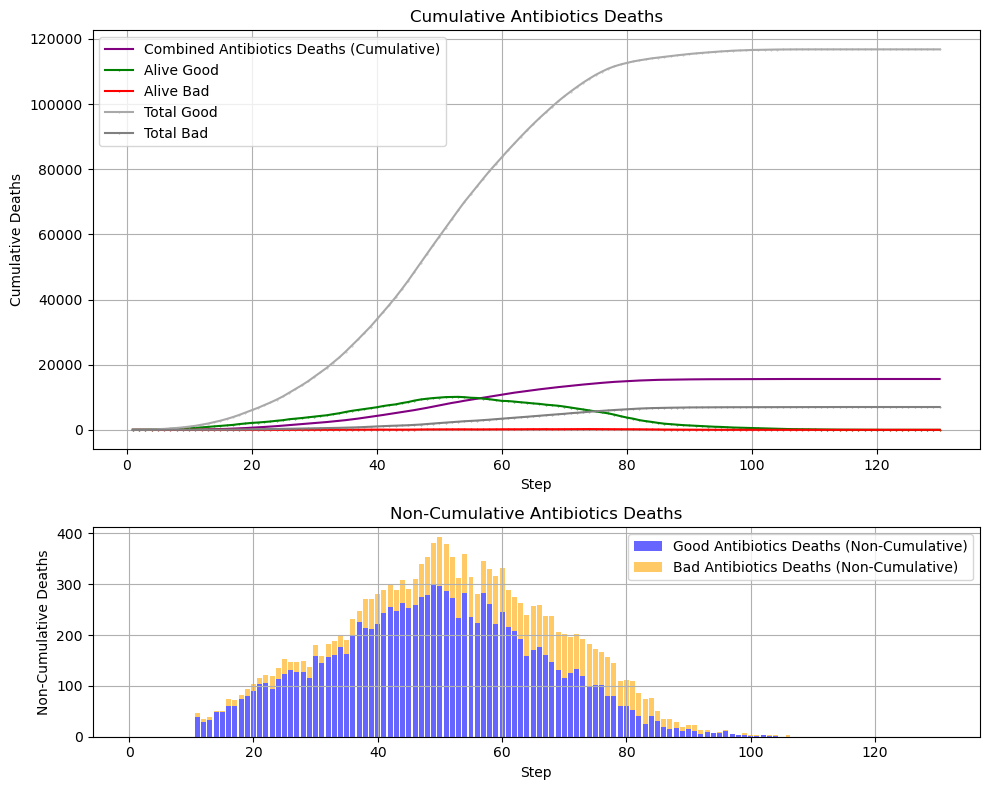

In [10]:
def visualize_bacteria_progression(simulation):
    summaries = simulation.bookkeeper.step_summaries

    # Unpack the summaries
    steps = [s['step'] for s in summaries]
    alive_good = [s['alive_good'] for s in summaries]
    alive_bad = [s['alive_bad'] for s in summaries]
    total_good = [s['alive_good'] + s['dead_good'] for s in summaries]
    total_bad = [s['alive_bad'] + s['dead_bad'] for s in summaries]
    good_total_antibiotics_deaths = [s['good_dead_due_to_antibiotics'] for s in summaries]
    bad_total_antibiotics_deaths = [s['bad_dead_due_to_antibiotics'] for s in summaries]

    combined_cumulative_deaths = [g + b for g, b in zip(good_total_antibiotics_deaths, bad_total_antibiotics_deaths)]


    # Calculate non-cumulative antibiotics deaths
    good_non_cumulative_deaths = np.diff([0] + good_total_antibiotics_deaths)
    bad_non_cumulative_deaths = np.diff([0] + bad_total_antibiotics_deaths)

    # Create the figure and subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

    # Plot cumulative antibiotics deaths (original plot)
    axs[0].plot(steps, combined_cumulative_deaths, label="Combined Antibiotics Deaths (Cumulative)", color='purple')

    axs[0].plot(steps, alive_good, label="Alive Good", marker='o', markersize=0.3, color='green')
    axs[0].plot(steps, alive_bad, label="Alive Bad", marker='o', markersize=0.3, color='red')
    axs[0].plot(steps, total_good, label="Total Good", marker='o', markersize=0.3, color='darkgray')
    axs[0].plot(steps, total_bad, label="Total Bad", marker='o', markersize=0.3, color='gray')
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Cumulative Deaths")
    axs[0].set_title("Cumulative Antibiotics Deaths")
    axs[0].legend()
    axs[0].grid(True)

    # Plot non-cumulative antibiotics deaths (new plot)
    axs[1].bar(steps, good_non_cumulative_deaths, label="Good Antibiotics Deaths (Non-Cumulative)", color='blue', alpha=0.6)
    axs[1].bar(steps, bad_non_cumulative_deaths, label="Bad Antibiotics Deaths (Non-Cumulative)", color='orange', alpha=0.6, bottom=good_non_cumulative_deaths)
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Non-Cumulative Deaths")
    axs[1].set_title("Non-Cumulative Antibiotics Deaths")
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout for better comparison
    plt.tight_layout()
    plt.savefig("bacteria_progression.png")
    plt.show()
for i, sim in enumerate(trial_data):
    print(f"Visualizing bacteria progression for trial {i}")
    visualize_bacteria_progression(sim)


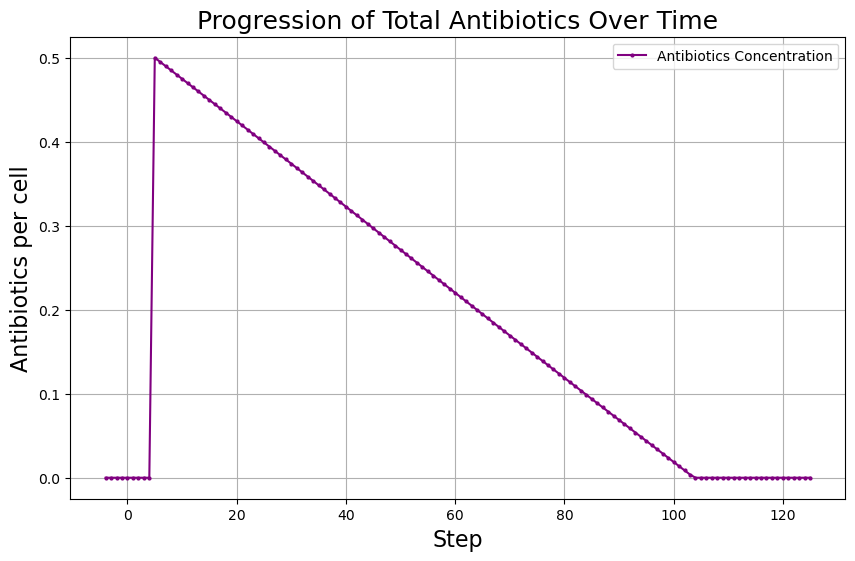

In [ ]:
def visualize_antibiotics_progression(simulation):
    """
    Visualize the progression of the total antibiotics concentration in the system over time.
    """
    # Extract the step summaries from the bookkeeper
    summaries = simulation.bookkeeper.step_summaries

    # Extract the steps and antibiotics concentration values
    steps = [s['step']-5 for s in summaries]
    antibiotics_concentration = [s['antibiotics_concentration']/125000 for s in summaries]

    # Plot the progression
    plt.figure(figsize=(10, 6))
    plt.plot(steps, antibiotics_concentration, label="Antibiotics", color="purple", marker='o', markersize=2)
    plt.xlabel("Step", fontsize=16)
    plt.ylabel("Antibiotics per cell", fontsize=16)
    plt.title("Progression of Antibiotics Over Time", fontsize=18)
    plt.legend(['Antibiotics Concentration'])
    plt.grid(True)
    plt.savefig("antibiotics_progression.png")
    plt.show()
visualize_antibiotics_progression(trial_data[0])  # Visualize for the first trial as an example

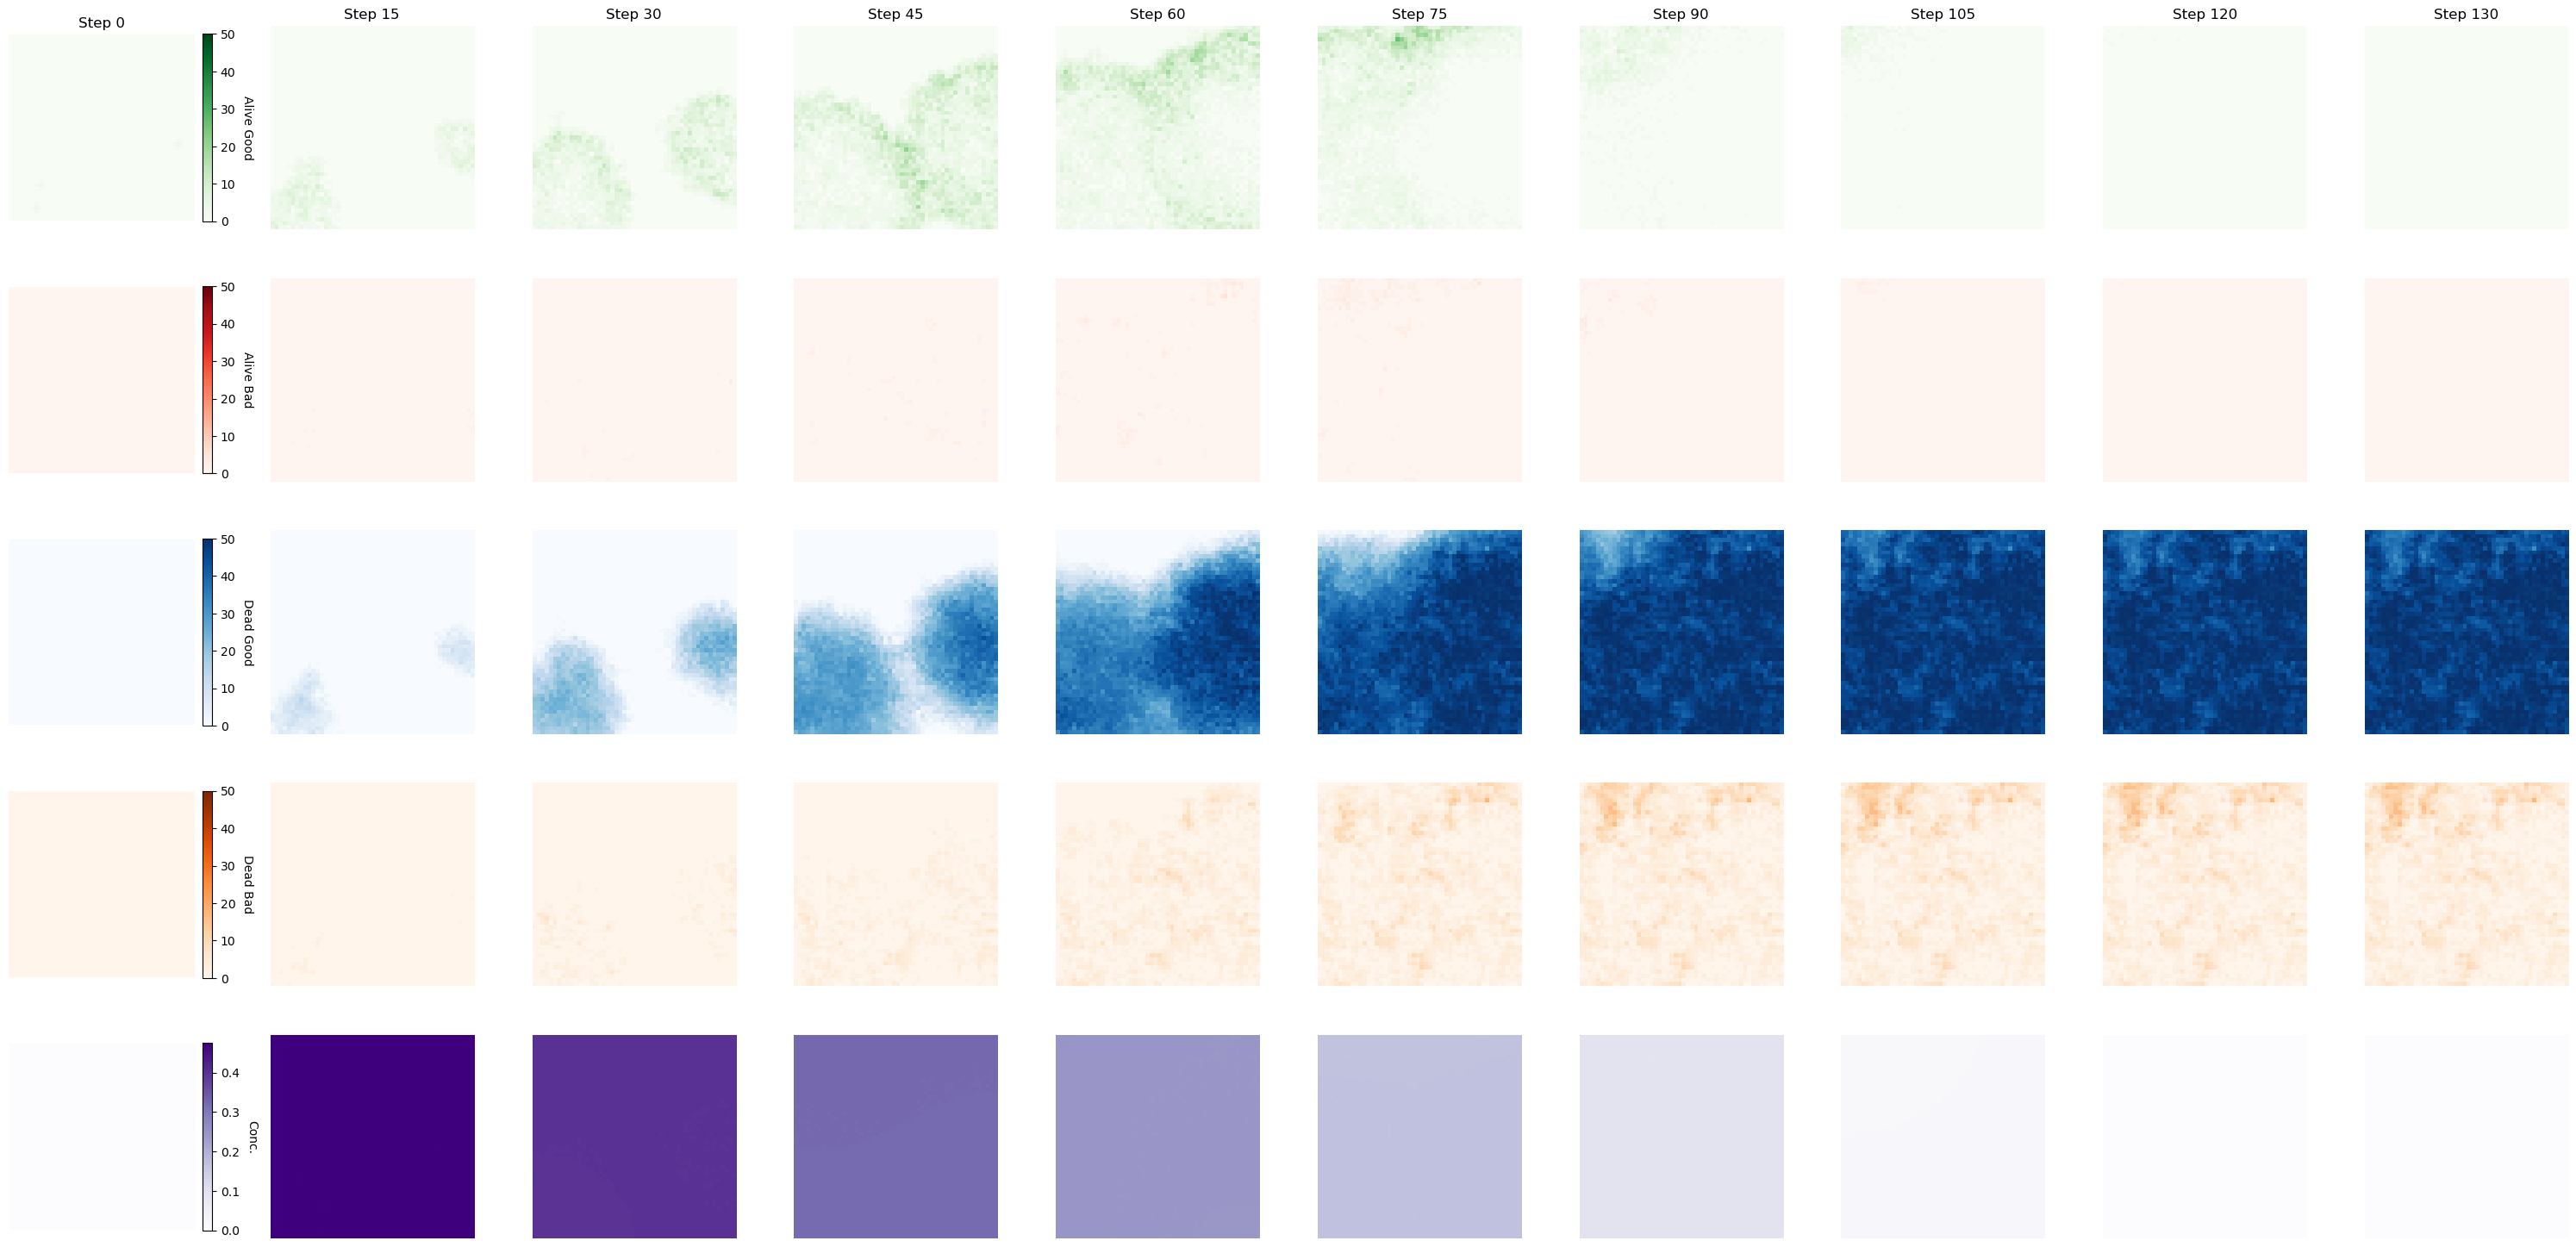

In [3]:
from matplotlib.colors import ListedColormap

def visualize_history_separate(grid_history, grid_interval, grid_size, grid_height, antibiotics_history=None, last_step=None):
    """
    Visualize the simulation history by aggregating all layers for each snapshot into
    five heatmaps (rows) showing:
      1. Alive Good (state == 1)
      2. Alive Bad (state == -1)
      3. Dead Good (state == 2)
      4. Dead Bad (state == -2)
      5. Antibiotics concentration (average over layers)
    
    Each column corresponds to one snapshot taken at an interval of 'grid_interval'.
    The counts for bacteria states are computed by reshaping each snapshot into
    (grid_height, grid_size, grid_size) and summing over the layers.
    For antibiotics, the mean concentration is computed per cell across layers.
    """
    # Define the information for the four bacteria state rows.
    # Note: The order here is as desired.
    state_info = [
        {"label": "Alive Good", "state": 1, "cmap": "Greens"},
        {"label": "Alive Bad",  "state": -1, "cmap": "Reds"},
        {"label": "Dead Good",  "state": 2, "cmap": "Blues"},
        {"label": "Dead Bad",   "state": -2, "cmap": "Oranges"}
    ]
    
    num_snapshots = len(grid_history)
    num_rows = len(state_info) + 1  # extra row for antibiotics
    
    # Pre-calculate global max for antibiotics row if antibiotics_history is provided.
    global_max_antibiotics = None
    if antibiotics_history is not None:
        aggregated_antibiotics_all = []
        for antib in antibiotics_history:
            grid_antib = np.array(antib).reshape((grid_height, grid_size, grid_size))
            agg_antib = np.mean(grid_antib, axis=0)  # average over layers
            aggregated_antibiotics_all.append(agg_antib)
        global_max_antibiotics = max(agg.max() for agg in aggregated_antibiotics_all)
    
    # Create the subplots: rows = 5, columns = snapshots
    fig, axs = plt.subplots(num_rows, num_snapshots, figsize=(num_snapshots * 3, num_rows * 3), squeeze=False)
    
    # Loop over snapshots for the bacteria states rows.
    for j, snapshot in enumerate(grid_history):
        # Reshape snapshot into (grid_height, grid_size, grid_size)
        grid_3d = np.array(snapshot).reshape((grid_height, grid_size, grid_size))
        # For each bacteria state row, compute aggregated counts.
        for i, info in enumerate(state_info):
            # Create a binary grid for the given state, then sum over layers.
            binary_grid = (grid_3d == info["state"]).astype(int)
            aggregated = np.sum(binary_grid, axis=0)
            ax = axs[i, j]
            im = ax.imshow(aggregated, cmap=info["cmap"], vmin=0, vmax=grid_height)
            # For the top row of bacteria states, set the column title.
            if i == 0:
                step_label = f"Step {j * grid_interval}" if j < num_snapshots - 1 else f"Step {last_step}"
                ax.set_title(step_label)
            # Label the first column with the row's label.
            if j == 0:
                ax.set_ylabel(info["label"], fontsize=12)
            ax.axis("off")
            # Add colorbar only for the first column.
            if j == 0:
                cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
                cbar.set_label(f"{info['label']}", rotation=270, labelpad=15)
    
    # Now add the final row for antibiotics concentration if provided.
    if antibiotics_history is not None:
        row_idx = num_rows - 1
        for j, antib_snapshot in enumerate(antibiotics_history):
            grid_antib = np.array(antib_snapshot).reshape((grid_height, grid_size, grid_size))
            # Compute the mean concentration across layers.
            aggregated_antib = np.mean(grid_antib, axis=0)
            ax = axs[row_idx, j]
            im = ax.imshow(aggregated_antib, cmap="Purples", vmin=0, vmax=global_max_antibiotics)
            if j == 0:
                ax.set_ylabel("Antibiotics", fontsize=12)
            ax.axis("off")
            # Add colorbar only for the first column.
            if j == 0:
                cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
                cbar.set_label("Conc.", rotation=270, labelpad=15)
    
    fig.tight_layout()
    fig.savefig("aggregated_3d_grid_history_with_antibiotics.png")
    plt.show()
simulation_nomber = 0

visualize_history_separate(
    grid_history=trial_data[simulation_nomber].grid_history,
    grid_interval=grid_interval,
    grid_size=grid_size,
    grid_height=grid_height,
    antibiotics_history=trial_data[simulation_nomber].antibiotics_history,
    last_step=int(trial_data[simulation_nomber].steps)
)

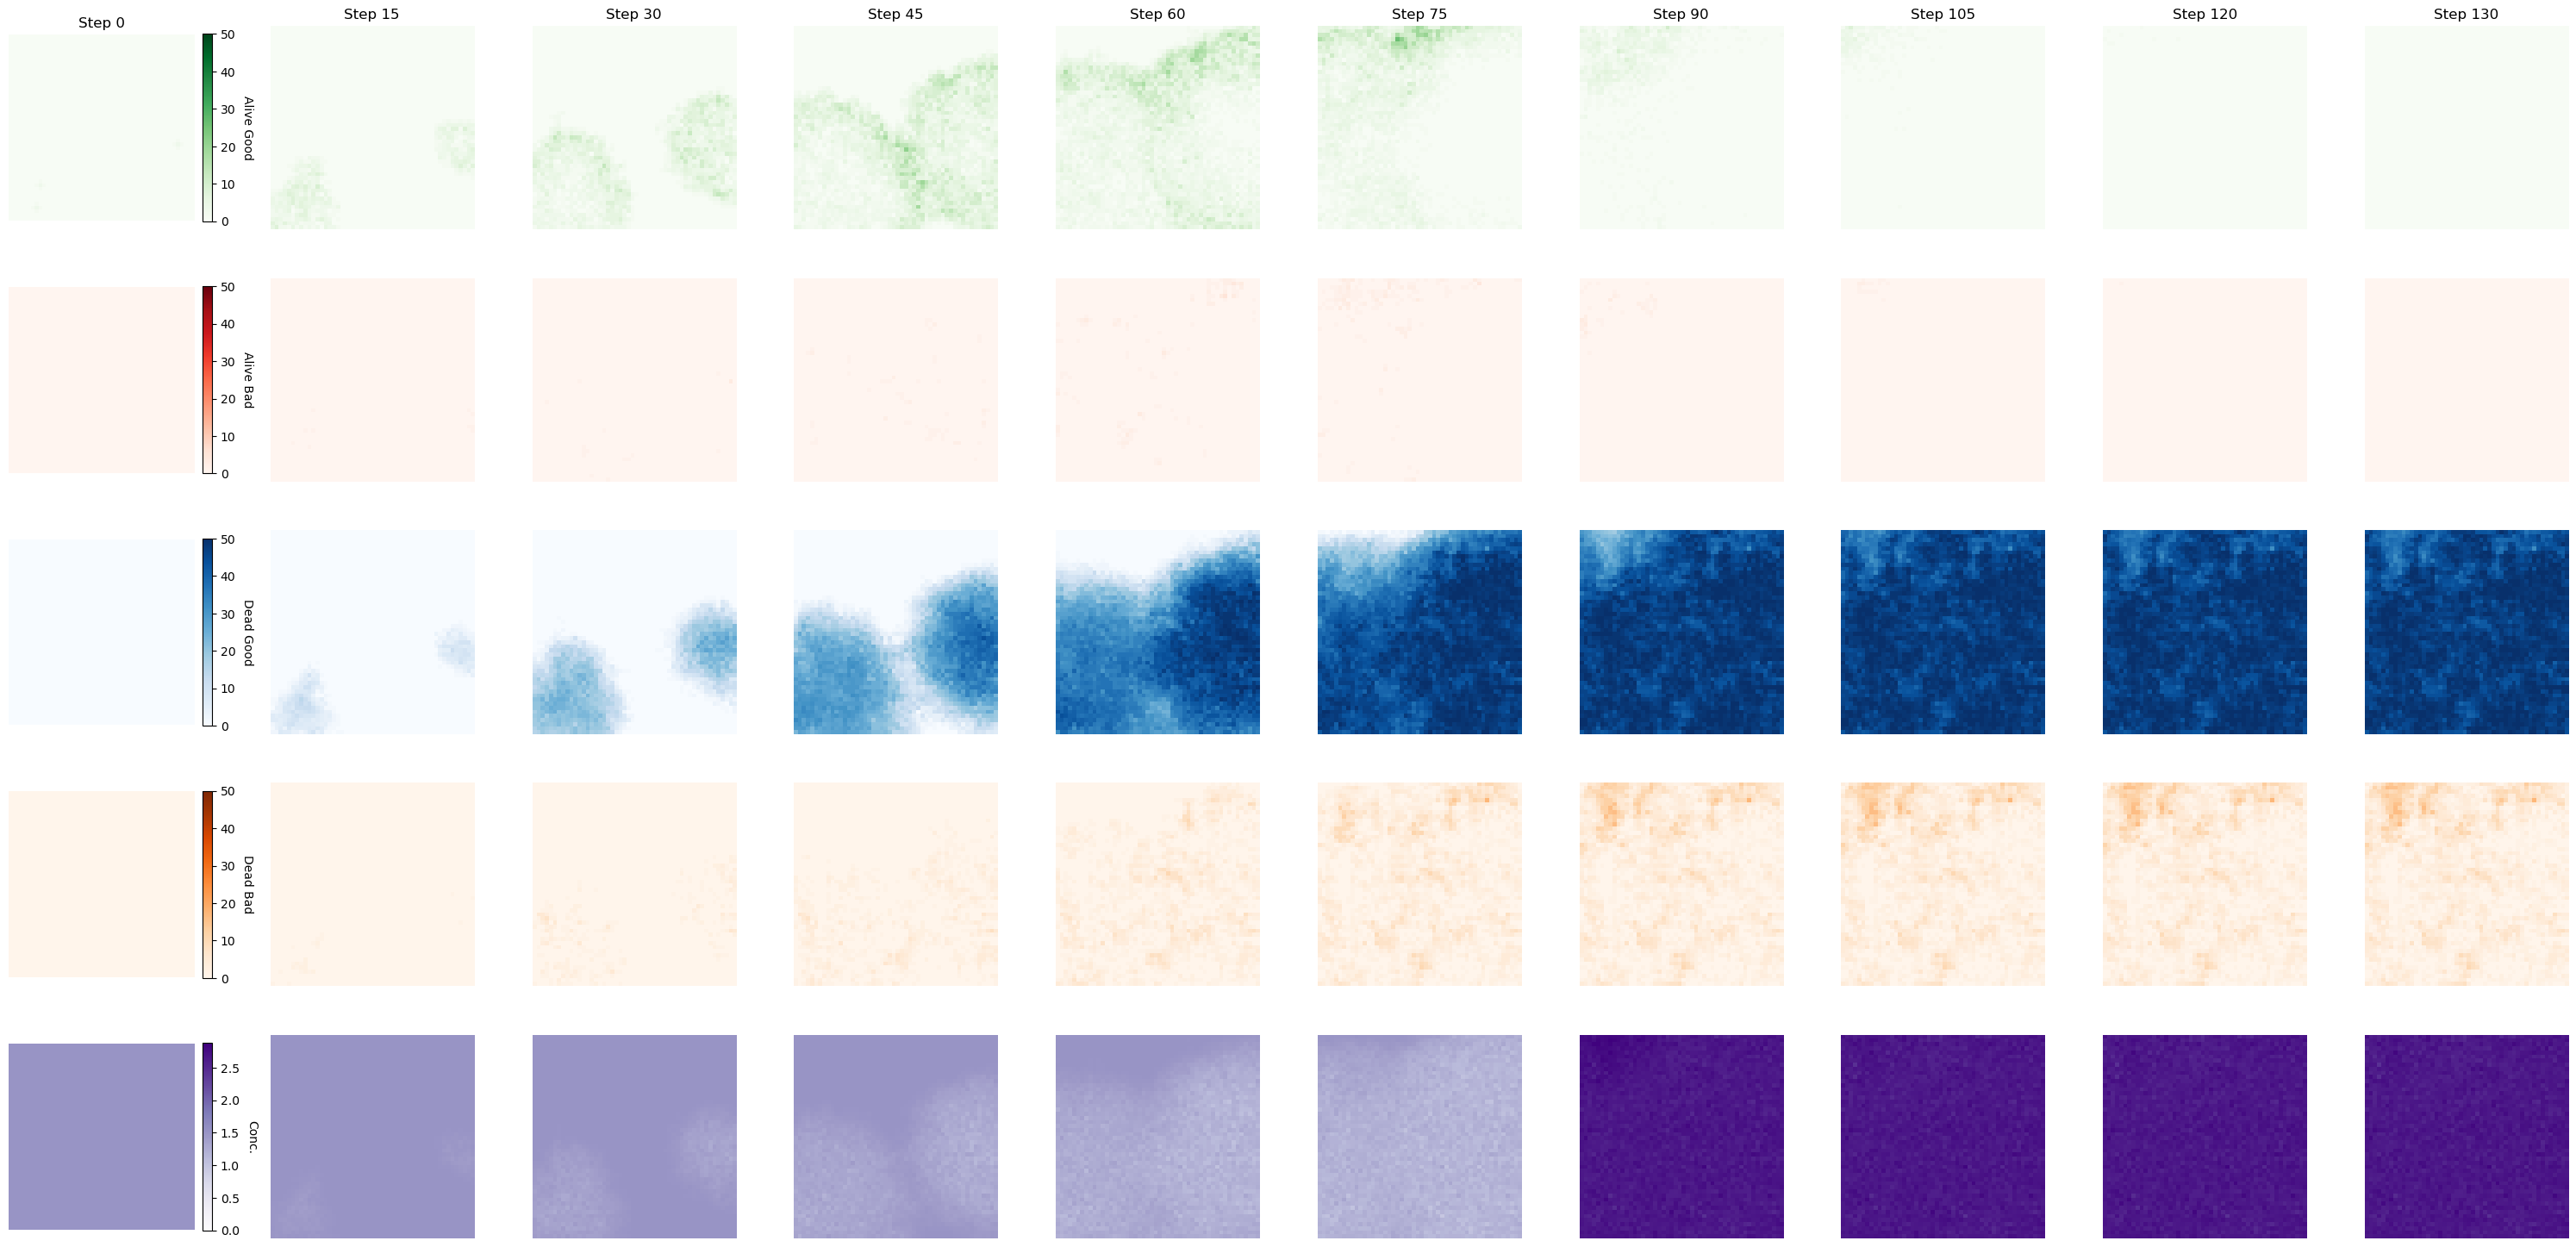

In [4]:
from matplotlib.colors import ListedColormap

def visualize_history_separate(grid_history, grid_interval, grid_size, grid_height, antibiotics_history=None, last_step=None):
    """
    Visualize the simulation history by aggregating all layers for each snapshot into
    five heatmaps (rows) showing:
      1. Alive Good (state == 1)
      2. Alive Bad (state == -1)
      3. Dead Good (state == 2)
      4. Dead Bad (state == -2)
      5. Antibiotics concentration (average over layers)
    
    Each column corresponds to one snapshot taken at an interval of 'grid_interval'.
    The counts for bacteria states are computed by reshaping each snapshot into
    (grid_height, grid_size, grid_size) and summing over the layers.
    For antibiotics, the mean concentration is computed per cell across layers.
    """
    # Define the information for the four bacteria state rows.
    # Note: The order here is as desired.
    state_info = [
        {"label": "Alive Good", "state": 1, "cmap": "Greens"},
        {"label": "Alive Bad",  "state": -1, "cmap": "Reds"},
        {"label": "Dead Good",  "state": 2, "cmap": "Blues"},
        {"label": "Dead Bad",   "state": -2, "cmap": "Oranges"}
    ]
    
    num_snapshots = len(grid_history)
    num_rows = len(state_info) + 1  # extra row for antibiotics
    
    # Pre-calculate global max for antibiotics row if antibiotics_history is provided.
    global_max_antibiotics = None
    if antibiotics_history is not None:
        aggregated_antibiotics_all = []
        for antib in antibiotics_history:
            grid_antib = np.array(antib).reshape((grid_height, grid_size, grid_size))
            agg_antib = np.mean(grid_antib, axis=0)  # average over layers
            aggregated_antibiotics_all.append(agg_antib)
        global_max_antibiotics = max(agg.max() for agg in aggregated_antibiotics_all)
    
    # Create the subplots: rows = 5, columns = snapshots
    fig, axs = plt.subplots(num_rows, num_snapshots, figsize=(num_snapshots * 3, num_rows * 3), squeeze=False)
    
    # Loop over snapshots for the bacteria states rows.
    for j, snapshot in enumerate(grid_history):
        # Reshape snapshot into (grid_height, grid_size, grid_size)
        grid_3d = np.array(snapshot).reshape((grid_height, grid_size, grid_size))
        # For each bacteria state row, compute aggregated counts.
        for i, info in enumerate(state_info):
            # Create a binary grid for the given state, then sum over layers.
            binary_grid = (grid_3d == info["state"]).astype(int)
            aggregated = np.sum(binary_grid, axis=0)
            ax = axs[i, j]
            im = ax.imshow(aggregated, cmap=info["cmap"], vmin=0, vmax=grid_height)
            # For the top row of bacteria states, set the column title.
            if i == 0:
                step_label = f"Step {j * grid_interval}" if j < num_snapshots - 1 else f"Step {last_step}"
                ax.set_title(step_label)
            # Label the first column with the row's label.
            if j == 0:
                ax.set_ylabel(info["label"], fontsize=12)
            ax.axis("off")
            # Add colorbar only for the first column.
            if j == 0:
                cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
                cbar.set_label(f"{info['label']}", rotation=270, labelpad=15)
    
    # Now add the final row for antibiotics concentration if provided.
    if antibiotics_history is not None:
        row_idx = num_rows - 1
        for j, antib_snapshot in enumerate(antibiotics_history):
            grid_antib = np.array(antib_snapshot).reshape((grid_height, grid_size, grid_size))
            # Compute the mean concentration across layers.
            aggregated_antib = np.mean(grid_antib, axis=0)
            ax = axs[row_idx, j]
            im = ax.imshow(aggregated_antib, cmap="Purples", vmin=0, vmax=global_max_antibiotics)
            if j == 0:
                ax.set_ylabel("Antibiotics", fontsize=12)
            ax.axis("off")
            # Add colorbar only for the first column.
            if j == 0:
                cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
                cbar.set_label("Conc.", rotation=270, labelpad=15)
    
    fig.tight_layout()
    fig.savefig("aggregated_3d_grid_history_with_antibiotics.png")
    plt.show()
simulation_nomber = 0

visualize_history_separate(
    grid_history=trial_data[simulation_nomber].grid_history,
    grid_interval=grid_interval,
    grid_size=grid_size,
    grid_height=grid_height,
    antibiotics_history=trial_data[simulation_nomber].food_history,
    last_step=int(trial_data[simulation_nomber].steps)
)

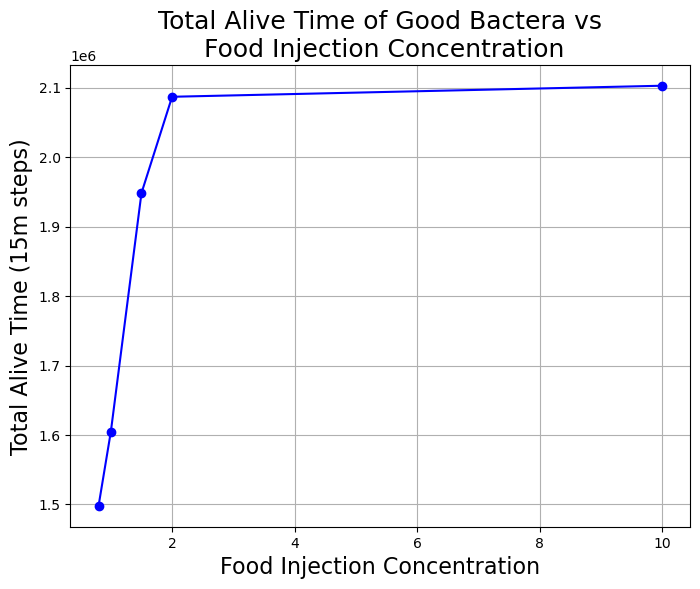

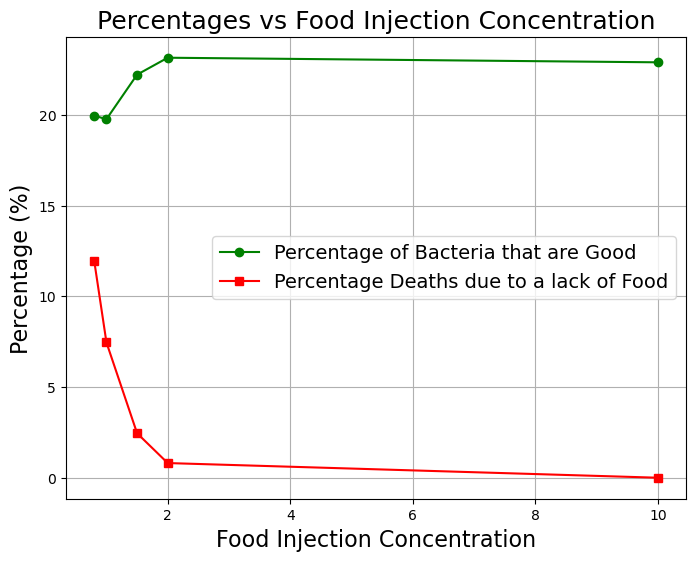

In [10]:
import matplotlib.pyplot as plt

# Example input lists (replace these with your actual data for each concentration)
total_good_deaths = [385156, 391848, 452995, 475357, 471771]       # Total good bacteria deaths per concentration
total_bad_deaths  = [1544362, 1590226, 1585296, 1577397, 1588029]         # Total bad bacteria deaths per concentration
good_deaths_food  = [46058, 29215, 11102, 3842, 0]            # Good bacteria deaths due to lack of food per concentration

# Calculate the percentage of the total bacteria (deaths) that were good.
percentage_good = []
for good, bad in zip(total_good_deaths, total_bad_deaths):
    total = good + bad
    if total == 0:
        percentage = 0
    else:
        percentage = (good / total) * 100
    percentage_good.append(percentage)

# Calculate the percentage of good deaths that were caused by lack of food.
percentage_deaths_no_food = []
for good, food_death in zip(total_good_deaths, good_deaths_food):
    if good == 0:
        perc_food = 0
    else:
        perc_food = (food_death / good) * 100
    percentage_deaths_no_food.append(perc_food)

# Define the food injection concentrations (x-axis)
concentrations = [0.8, 1, 1.5, 2, 10]

# Enter your data for each concentration.
# Replace the sample data below with your actual collected data.

# Total alive time for each concentration, e.g., measured in time units
total_alive_time = [1498201.907, 1604669.332, 1948159.066, 2086760.048, 2102664.902]


# Plot 1: Total Alive Time vs Food Injection Concentration
plt.figure(figsize=(8, 6))
plt.plot(concentrations, total_alive_time, marker='o', linestyle='-', color='blue')
plt.xlabel("Food Injection Concentration", fontsize=16)
plt.ylabel("Total Alive Time (15m steps)", fontsize=16)
plt.title("Total Alive Time of Good Bactera vs\n Food Injection Concentration", fontsize=18)
plt.grid(True)
plt.savefig("time alive.png")
plt.show()

# Plot 2: Percentages vs Food Injection Concentration
plt.figure(figsize=(8, 6))
plt.plot(concentrations, percentage_good, marker='o', linestyle='-', label="Percentage Good", color='green')
plt.plot(concentrations, percentage_deaths_no_food, marker='s', linestyle='-', label="Percentage Deaths (No Food)", color='red')
plt.xlabel("Food Injection Concentration", fontsize=16)
plt.ylabel("Percentage (%)", fontsize=16)
plt.title("Percentages vs Food Injection Concentration", fontsize=18)
plt.legend(["Percentage of Bacteria that are Good", "Percentage Deaths due to a lack of Food"], fontsize=14)
plt.grid(True)
plt.savefig("percentages_vs_food_injection_concentration.png")
plt.show()

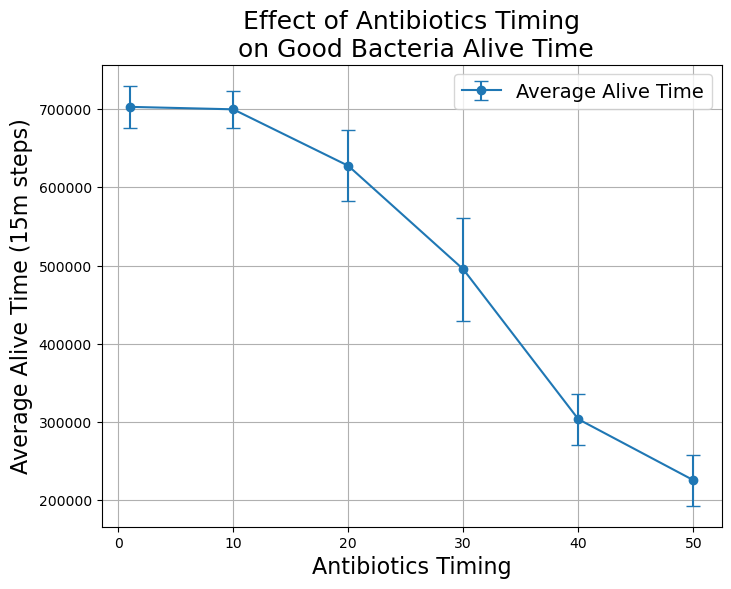

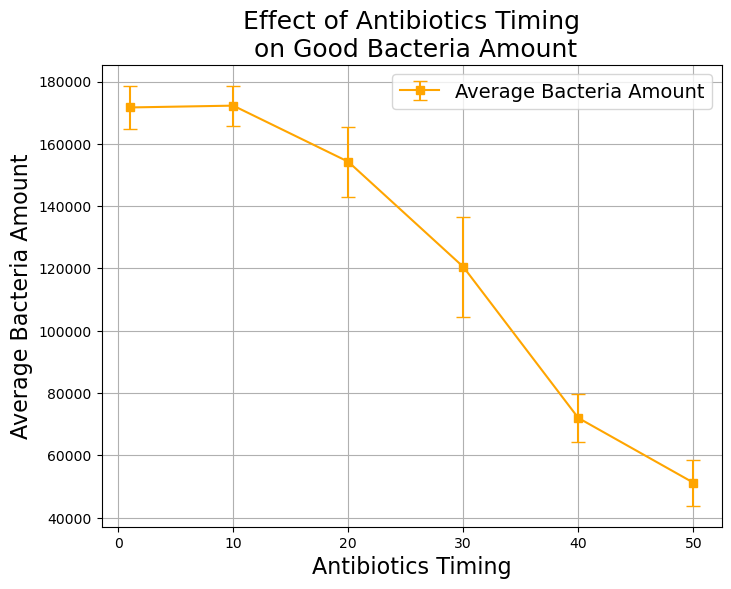

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW

# Example: For each antibiotic timing (10 datapoints) you provide a list of simulation outcomes.
# Replace these with your actual simulation result lists.
# Each element in alive_time_samples is a list containing simulation outcomes (e.g., alive times) at that timing.
alive_time_samples = [
    [734585, 674953, 731620, 725390, 676095, 658304, 736195, 732490, 725438, 635558],
    [699512, 732233, 713632, 696163, 720483, 612249, 714304, 696286, 703929, 710439],
    [548210, 682616, 620368, 659148, 495774, 672039, 607238, 681123, 684980, 625324],
    [502968, 466857, 583089, 537659, 452866, 611127, 556461, 278338, 487237, 477021],
    [341209, 311770, 302167, 221047, 287593, 318602, 330537, 385002, 274383, 264381],
    [260463, 272320, 189570, 195645, 200189, 285662, 230961, 192027, 276384, 153490]
]

# Reformatted simulation outcome lists for average bacteria amount
bacteria_amount_samples = [
    [178382, 165133, 178819, 178961, 166067, 159658, 180023, 179175, 176822, 153851],
    [174991, 179281, 176567, 169308, 177719, 148418, 176862, 170348, 174030, 175206],
    [134707, 167329, 153406, 162472, 121409, 165575, 148908, 167200, 168575, 153058],
    [121301, 113290, 141899, 130539, 109495, 149141, 135086, 68335, 119290, 116797],
    [80124, 73826, 72094, 53427, 67782, 75408, 79243, 92114, 64057, 61959],
    [58585, 62610, 43224, 44250, 45042, 64764, 53050, 44569, 61917, 34370]
]

# For the x-axis, e.g., antibiotic timing values (10 datapoints)
antibiotics_timings = [1,10,20,30,40,50]

def compute_mean_and_ci(data_lists):
    """
    For each list in data_lists, compute the mean and the half-width of the 95% confidence interval.
    Returns two lists: means and ci_errors.
    """
    means = []
    ci_errors = []
    for outcomes in data_lists:
        cs = DescrStatsW(outcomes)
        lower, upper = cs.tconfint_mean(alpha=0.05)
        mean_val = np.mean(outcomes)
        error = (upper - lower) / 2  # half-width of the confidence interval
        means.append(mean_val)
        ci_errors.append(error)
    return means, ci_errors

# Compute the mean and error for average alive time and bacteria amount
avg_alive_time, alive_time_ci = compute_mean_and_ci(alive_time_samples)
avg_bacteria_amount, bacteria_amount_ci = compute_mean_and_ci(bacteria_amount_samples)

# Plot 1: Average Alive Time vs Antibiotics Timing with confidence intervals
plt.figure(figsize=(8, 6))
plt.errorbar(antibiotics_timings, avg_alive_time, yerr=alive_time_ci, fmt='o-', capsize=5, label='Average Alive Time')
plt.xlabel("Antibiotics Timing", fontsize=16)
plt.ylabel("Average Alive Time (15m steps)", fontsize=16)
plt.title("Effect of Antibiotics Timing\n on Good Bacteria Alive Time", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("first_antibiotics_timing_effects_alive_time.png")
plt.show()

# Plot 2: Average Bacteria Amount vs Antibiotics Timing with confidence intervals
plt.figure(figsize=(8, 6))
plt.errorbar(antibiotics_timings, avg_bacteria_amount, yerr=bacteria_amount_ci, fmt='s-', capsize=5, color='orange', label='Average Bacteria Amount')
plt.xlabel("Antibiotics Timing", fontsize=16)
plt.ylabel("Average Bacteria Amount", fontsize=16)
plt.title("Effect of Antibiotics Timing\n on Good Bacteria Amount", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("first_antibiotics_timing_effects.png")
plt.show()

[531772.2, 700757.4, 643546.1, 579626.7, 436645.5, 358292.3] [54282.38426757869, 25234.72001686145, 28001.06935832952, 22603.989900131477, 29863.038968806737, 42598.06196764682] [123226.1, 171756.0, 167456.5, 159915.5, 136015.6, 124358.2] [12429.21366325309, 6518.062466940057, 7427.586724361434, 6470.930993167945, 9372.3259339637, 14631.650877827095]


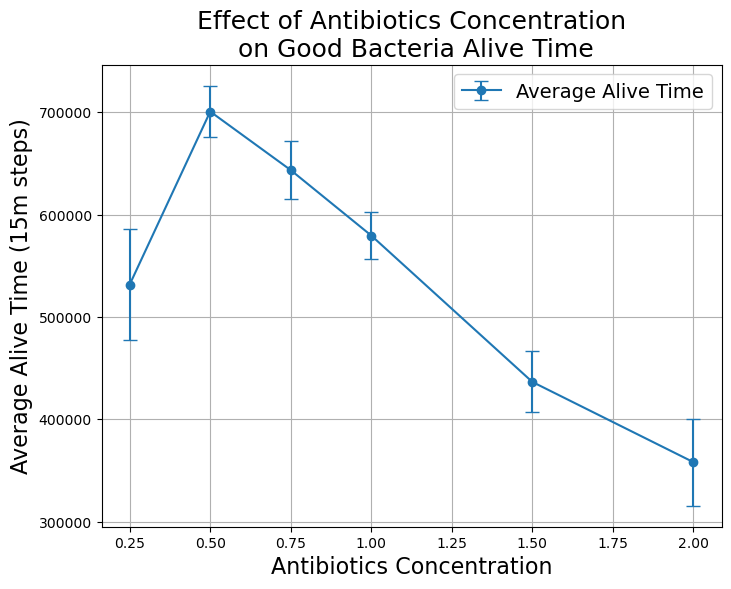

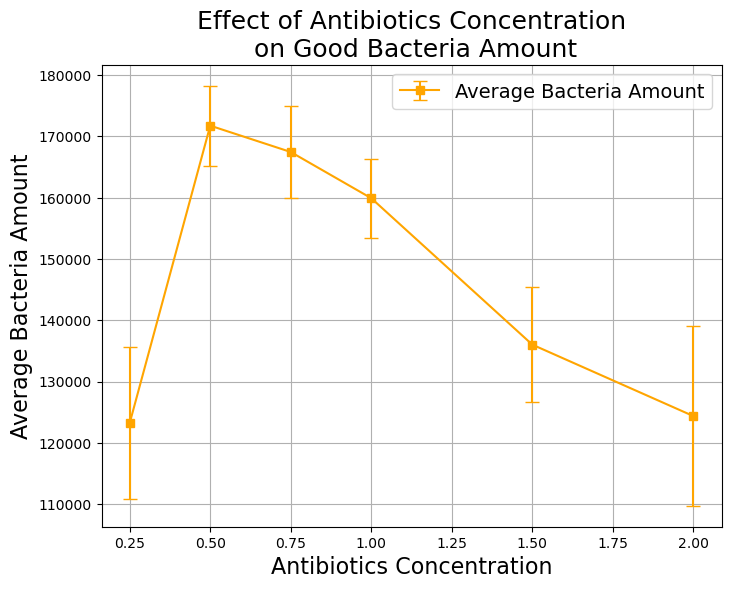

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW

# Example: For each antibiotic concentration (10 datapoints), provide a list of simulation outcomes.
# Replace these with your actual simulation result lists.
# Each element in alive_time_samples is a list containing simulation outcomes (e.g., alive times) at that concentration.
alive_time_samples = [
    [606523, 587816, 418892, 533177, 468981, 561237, 609037, 421820, 611640, 498599],
    [714946, 726215, 730299, 693210, 697967, 610910, 720668, 683901, 703132, 726326],
    [540814, 643541, 662335, 669204, 665948, 625637, 670517, 639393, 668445, 649627],
    [595205, 611172, 607095, 583623, 564537, 582096, 590458, 529998, 609599, 522484],
    [398302, 437747, 354164, 462813, 459524, 465150, 400051, 475609, 486039, 427056],
    [216752, 362394, 373171, 383950, 303217, 383774, 342476, 402525, 419257, 395407]
]

# Similarly, for bacteria amount at each concentration:
bacteria_amount_samples = [
    [140668, 136266, 97146, 123155, 107613, 130069, 140856, 98812, 141128, 116548],
    [175489, 178509, 178891, 168905, 170800, 149093, 176892, 166078, 174066, 178837],
    [140432, 167438, 173947, 173007, 174933, 162742, 173842, 164784, 173239, 170201],
    [164725, 168415, 168894, 159883, 154355, 161003, 162732, 145671, 168931, 144546],
    [124113, 136693, 110157, 144325, 141450, 145110, 125407, 149503, 151541, 131857],
    [75230, 127816, 130562, 132661, 105231, 132276, 119468, 139004, 144747, 136587]
]

# For the x-axis, e.g., antibiotic concentration values (10 datapoints)
antibiotics_concentrations = [0.25, 0.5, 0.75, 1, 1.5, 2]

def compute_mean_and_ci(data_lists):
    """
    For each list in data_lists, compute the mean and the half-width of the 95% confidence interval.
    Returns two lists: means and ci_errors.
    """
    means = []
    ci_errors = []
    for outcomes in data_lists:
        cs = DescrStatsW(outcomes)
        lower, upper = cs.tconfint_mean(alpha=0.05)
        mean_val = np.mean(outcomes)
        error = (upper - lower) / 2  # half-width of the confidence interval
        means.append(mean_val)
        ci_errors.append(error)
    return means, ci_errors

# Compute the mean and error for average alive time and bacteria amount
avg_alive_time, alive_time_ci = compute_mean_and_ci(alive_time_samples)
avg_bacteria_amount, bacteria_amount_ci = compute_mean_and_ci(bacteria_amount_samples)
print(avg_alive_time,  alive_time_ci, avg_bacteria_amount, bacteria_amount_ci)
# Plot 1: Average Alive Time vs Antibiotics Concentration with confidence intervals
plt.figure(figsize=(8, 6))
plt.errorbar(antibiotics_concentrations, avg_alive_time, yerr=alive_time_ci, fmt='o-', capsize=5, label='Average Alive Time')
plt.xlabel("Antibiotics Concentration", fontsize=16)
plt.ylabel("Average Alive Time (15m steps)", fontsize=16)
plt.title("Effect of Antibiotics Concentration\n on Good Bacteria Alive Time", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("second_antibiotics_concentration_effects_alive_time.png")
plt.show()

# Plot 2: Average Bacteria Amount vs Antibiotics Concentration with confidence intervals
plt.figure(figsize=(8, 6))
plt.errorbar(antibiotics_concentrations, avg_bacteria_amount, yerr=bacteria_amount_ci, fmt='s-', capsize=5, color='orange', label='Average Bacteria Amount')
plt.xlabel("Antibiotics Concentration", fontsize=16)
plt.ylabel("Average Bacteria Amount", fontsize=16)
plt.title("Effect of Antibiotics Concentration\n on Good Bacteria Amount", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("second_antibiotics_concentration_effects.png")
plt.show()

712006.8 10769.563454532064 175620.45 2530.345288670622


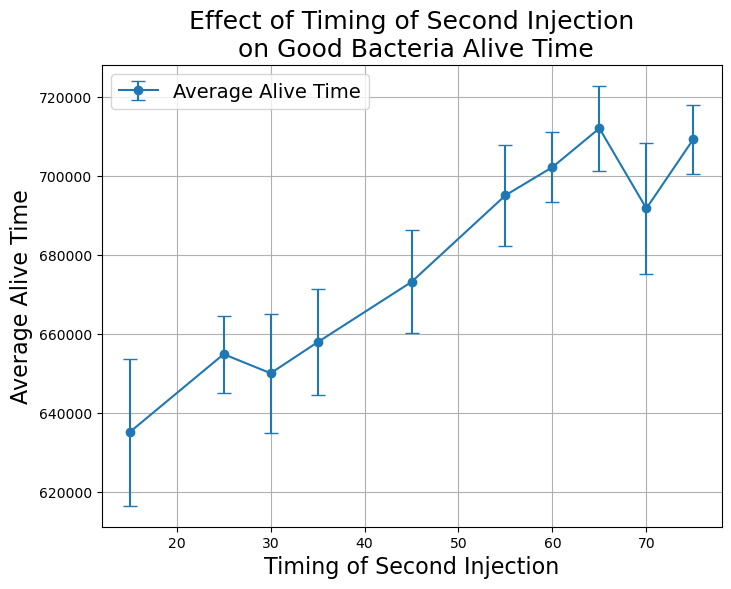

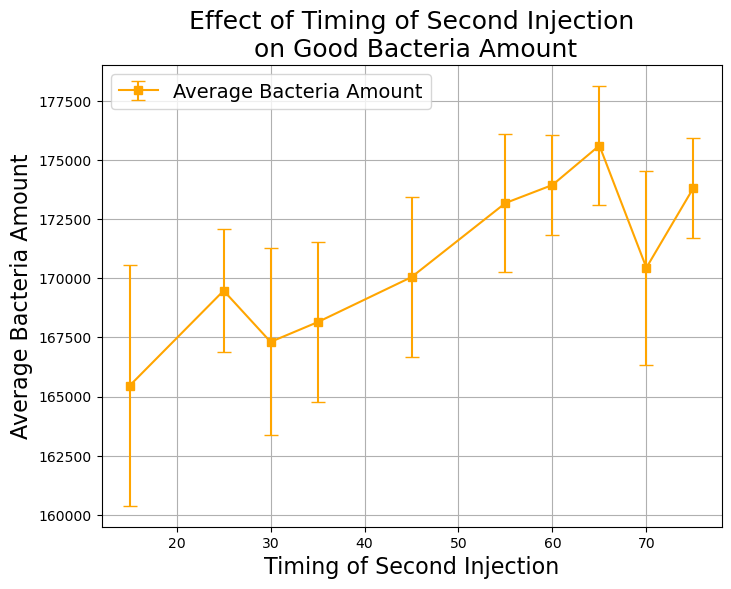

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW

# Example: For each timing of the second injection (10 datapoints), provide a list of simulation outcomes.
# Replace these with your actual simulation result lists.
# Each element in alive_time_samples is a list containing simulation outcomes (e.g., alive times) at that timing.
alive_time_samples = [
    [663994, 580380, 662058, 660870, 633720, 645091, 656500, 634059, 655820, 667036, 621846, 669433, 579019, 648108, 628240, 505943, 627473, 651638, 649032, 664234],
    [677412, 603501, 669899, 673579, 641891, 631271, 677071, 675009, 673024, 676207, 663531, 664355, 631172, 620514, 649189, 652133, 662696, 656674, 650928, 648462],
    [634772, 628699, 667568, 679048, 593366, 668654, 670169, 634584, 675785, 563235, 610897, 685602, 627065, 673697, 671850, 654785, 667138, 659418, 675738, 660151],
    [604610, 632315, 649407, 683210, 604037, 680264, 640987, 682355, 656732, 626870, 620331, 662315, 685284, 693716, 689182, 679873, 648030, 657503, 686272, 675616],
    [686011, 693769, 689124, 707034, 690898, 686612, 684678, 621198, 700756, 673831, 630545, 635640, 694316, 670619, 635895, 625597, 661336, 683968, 696680, 695184],
    [722546, 712355, 686679, 648620, 696646, 718851, 688472, 668919, 710897, 681731, 717383, 709301, 695995, 689050, 713511, 711043, 718622, 614708, 678170, 718097],
    [696844, 713222, 704286, 646157, 705457, 720084, 715319, 702629, 699947, 731684, 713832, 699892, 708388, 694902, 710775, 684243, 667231, 715435, 711466, 702142],
    [714520, 635446, 715359, 733871, 718735, 688909, 726825, 727819, 726471, 712573, 727474, 730215, 708396, 705201, 719698, 673606, 711485, 725529, 719639, 718365],
    [710869, 701440, 716539, 734441, 722172, 702665, 652809, 704791, 682267, 720400, 705523, 694698, 636645, 736736, 627209, 703685, 710756, 661620, 699128, 610820],
    [718111, 693472, 697069, 731438, 728765, 720096, 708001, 719073, 717643, 665310, 713476, 680637, 692395, 732185, 719386, 711593, 705680, 720834, 728793, 681441]
]

# Similarly, for bacteria amount at each timing:
bacteria_amount_samples = [
    [174823, 150287, 173449, 173656, 164702, 167499, 172106, 164758, 173201, 173755, 161837, 173785, 149841, 167752, 164201, 130945, 162566, 169906, 167167, 173057],
    [174909, 156317, 173858, 174032, 167458, 163182, 175219, 174989, 175063, 174479, 172144, 171979, 161746, 160521, 167718, 167274, 172862, 169397, 167755, 168700],
    [163511, 161355, 172775, 175156, 152389, 173705, 170709, 162341, 173118, 144826, 156599, 175609, 162781, 174299, 172704, 168995, 172918, 168337, 174872, 169271],
    [154615, 162048, 165860, 174374, 155072, 174408, 163635, 173993, 168198, 161175, 157569, 168929, 176486, 175513, 176065, 172352, 165570, 167653, 175941, 173505],
    [172830, 175737, 174722, 177698, 173672, 174153, 173611, 157436, 177276, 171105, 158956, 159611, 175739, 168767, 160012, 157541, 167244, 173678, 176438, 174868],
    [178890, 177475, 172099, 162630, 174276, 178958, 171634, 167583, 176629, 170575, 177530, 176615, 172762, 171316, 176752, 176665, 178901, 154111, 170071, 178296],
    [171761, 178026, 175582, 160964, 175529, 178446, 176639, 174004, 172094, 179888, 178012, 173272, 175703, 172984, 174789, 170390, 164804, 176989, 175294, 173860],
    [177293, 157459, 175630, 180425, 179127, 170731, 178725, 179547, 179956, 174544, 178820, 179749, 173997, 175230, 176514, 166887, 176082, 178679, 176215, 176799],
    [173961, 172125, 176821, 180542, 178012, 173437, 161269, 173971, 167227, 177849, 174499, 171296, 156976, 180659, 155207, 173706, 175797, 163005, 173265, 149404],
    [176386, 168942, 170707, 180127, 177379, 176697, 172947, 176265, 176752, 163524, 175160, 166424, 169129, 179202, 175141, 173993, 174696, 176634, 177892, 168473]
]

# For the x-axis, e.g., timing of the second injection values (10 datapoints)
second_injection_timings = [15, 25, 30, 35, 45, 55, 60, 65, 70, 75]

def compute_mean_and_ci(data_lists):
    """
    For each list in data_lists, compute the mean and the half-width of the 95% confidence interval.
    Returns two lists: means and ci_errors.
    """
    means = []
    ci_errors = []
    for outcomes in data_lists:
        cs = DescrStatsW(outcomes)
        lower, upper = cs.tconfint_mean(alpha=0.05)
        mean_val = np.mean(outcomes)
        error = (upper - lower) / 2  # half-width of the confidence interval
        means.append(mean_val)
        ci_errors.append(error)
    return means, ci_errors

# Compute the mean and error for average alive time and bacteria amount
avg_alive_time, alive_time_ci = compute_mean_and_ci(alive_time_samples)
avg_bacteria_amount, bacteria_amount_ci = compute_mean_and_ci(bacteria_amount_samples)
print(avg_alive_time[7],  alive_time_ci[7], avg_bacteria_amount[7], bacteria_amount_ci[7])
# Plot 1: Average Alive Time vs Timing of Second Injection with confidence intervals
plt.figure(figsize=(8, 6))
plt.errorbar(second_injection_timings, avg_alive_time, yerr=alive_time_ci, fmt='o-', capsize=5, label='Average Alive Time')
plt.xlabel("Timing of Second Injection", fontsize=16)
plt.ylabel("Average Alive Time", fontsize=16)
plt.title("Effect of Timing of Second Injection\n on Good Bacteria Alive Time", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("second_injection_timing_effects_alive_time.png")
plt.show()

# Plot 2: Average Bacteria Amount vs Timing of Second Injection with confidence intervals
plt.figure(figsize=(8, 6))
plt.errorbar(second_injection_timings, avg_bacteria_amount, yerr=bacteria_amount_ci, fmt='s-', capsize=5, color='orange', label='Average Bacteria Amount')
plt.xlabel("Timing of Second Injection", fontsize=16)
plt.ylabel("Average Bacteria Amount", fontsize=16)
plt.title("Effect of Timing of Second Injection\n on Good Bacteria Amount", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("second_injection_timing_effects.png")
plt.show()

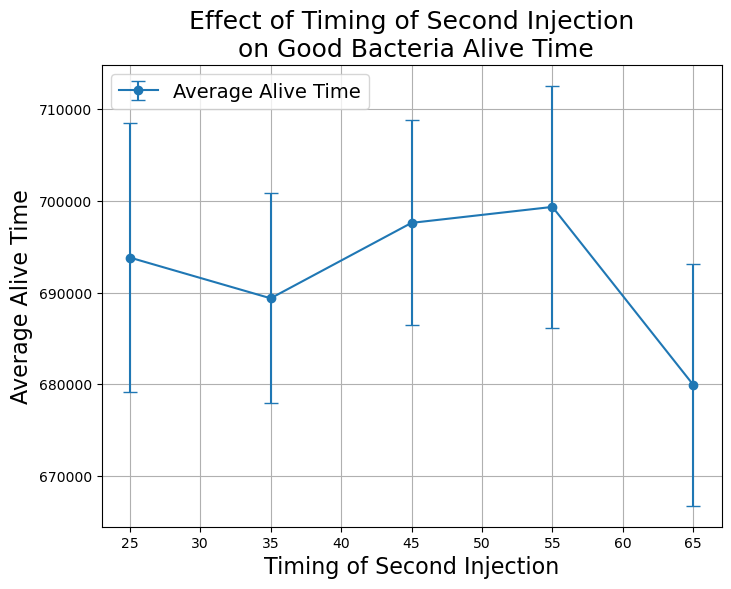

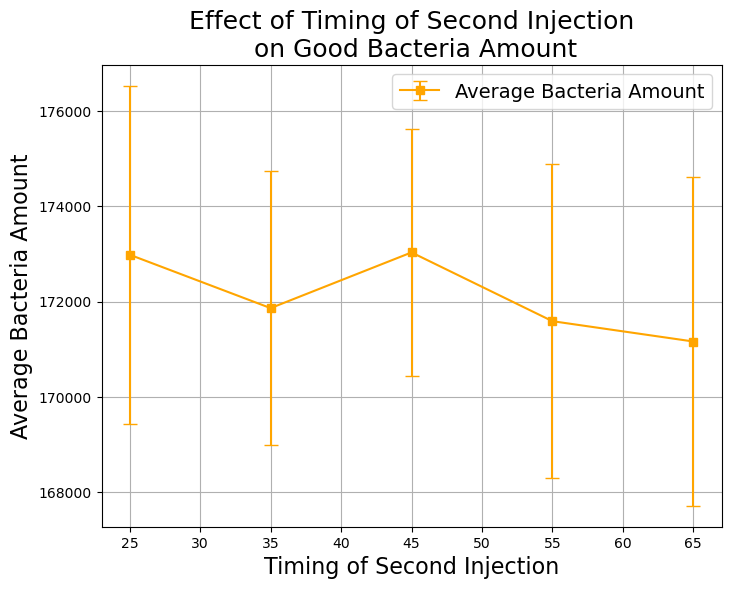

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW

# Example: For each timing of the second injection (10 datapoints), provide a list of simulation outcomes.
# Replace these with your actual simulation result lists.
# Each element in alive_time_samples is a list containing simulation outcomes (e.g., alive times) at that timing.
alive_time_samples = [
    [721910, 723136, 721129, 716472, 712262, 716521, 680200, 710041, 706623, 705155, 709976, 655661, 706579, 691998, 709891, 655797, 603136, 678244, 649631, 702107],
    [634660, 712308, 705083, 648133, 694389, 715998, 702743, 714410, 710847, 680997, 704020, 670968, 696877, 648188, 708513, 674304, 666210, 702814, 701767, 694431],
    [677086, 731133, 718256, 614645, 690599, 702544, 727202, 719073, 726913, 718774, 722546, 712355, 686679, 648620, 696646, 718851, 688472, 668919, 710897, 681731, 717383, 709301, 695995, 689050, 713511, 711043, 718622, 614708, 678170, 718097],
    [736108, 659060, 659425, 724113, 729143, 687266, 655561, 723573, 716632, 692806, 723578, 708517, 721745, 703504, 677376, 709225, 697085, 715817, 636958, 709150],
    [711719, 703228, 704654, 668345, 679430, 699265, 643148, 630202, 693990, 679339, 656633, 703223, 702536, 628987, 659066, 687714, 704399, 706808, 636452, 699827]
]

# Similarly, for bacteria amount at each timing:
bacteria_amount_samples = [
    [178865, 178594, 178469, 179489, 176335, 177329, 167292, 174981, 175123, 175040, 179131, 164134, 177358, 173099, 178820, 163937, 151122, 169842, 162530, 178152],
    [156718, 176153, 173456, 160905, 172219, 177569, 174018, 178159, 175976, 169503, 175820, 169373, 175631, 162425, 177561, 168176, 166865, 176426, 176696, 173610],
    [165872, 178840, 177828, 151847, 169283, 173757, 177133, 177115, 179204, 176264, 178890, 177475, 172099, 162630, 174276, 178958, 171634, 167583, 176629, 170575, 177530, 176615, 172762, 171316, 176752, 176665, 178901, 154111, 170071, 178296],
    [180058, 160198, 160364, 174376, 177995, 167590, 159895, 176069, 174217, 170517, 178209, 175410, 176585, 173127, 167463, 176493, 170848, 179263, 158024, 175080],
    [178998, 177620, 178374, 167367, 171351, 176497, 162066, 158111, 174598, 172002, 162970, 176879, 176655, 159130, 164733, 174657, 177051, 177428, 159824, 176949]
]
# For the x-axis, e.g., timing of the second injection values (10 datapoints)
second_injection_timings = [25, 35, 45, 55, 65]

def compute_mean_and_ci(data_lists):
    """
    For each list in data_lists, compute the mean and the half-width of the 95% confidence interval.
    Returns two lists: means and ci_errors.
    """
    means = []
    ci_errors = []
    for outcomes in data_lists:
        cs = DescrStatsW(outcomes)
        lower, upper = cs.tconfint_mean(alpha=0.05)
        mean_val = np.mean(outcomes)
        error = (upper - lower) / 2  # half-width of the confidence interval
        means.append(mean_val)
        ci_errors.append(error)
    return means, ci_errors

# Compute the mean and error for average alive time and bacteria amount
avg_alive_time, alive_time_ci = compute_mean_and_ci(alive_time_samples)
avg_bacteria_amount, bacteria_amount_ci = compute_mean_and_ci(bacteria_amount_samples)

# Plot 1: Average Alive Time vs Timing of Second Injection with confidence intervals
plt.figure(figsize=(8, 6))
plt.errorbar(second_injection_timings, avg_alive_time, yerr=alive_time_ci, fmt='o-', capsize=5, label='Average Alive Time')
plt.xlabel("Timing of Second Injection", fontsize=16)
plt.ylabel("Average Alive Time", fontsize=16)
plt.title("Effect of Timing of Second Injection\n on Good Bacteria Alive Time", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("second_injection_timing_effects_alive_time_1.png")
plt.show()

# Plot 2: Average Bacteria Amount vs Timing of Second Injection with confidence intervals
plt.figure(figsize=(8, 6))
plt.errorbar(second_injection_timings, avg_bacteria_amount, yerr=bacteria_amount_ci, fmt='s-', capsize=5, color='orange', label='Average Bacteria Amount')
plt.xlabel("Timing of Second Injection", fontsize=16)
plt.ylabel("Average Bacteria Amount", fontsize=16)
plt.title("Effect of Timing of Second Injection\n on Good Bacteria Amount", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("second_injection_timing_effects_1.png")
plt.show()

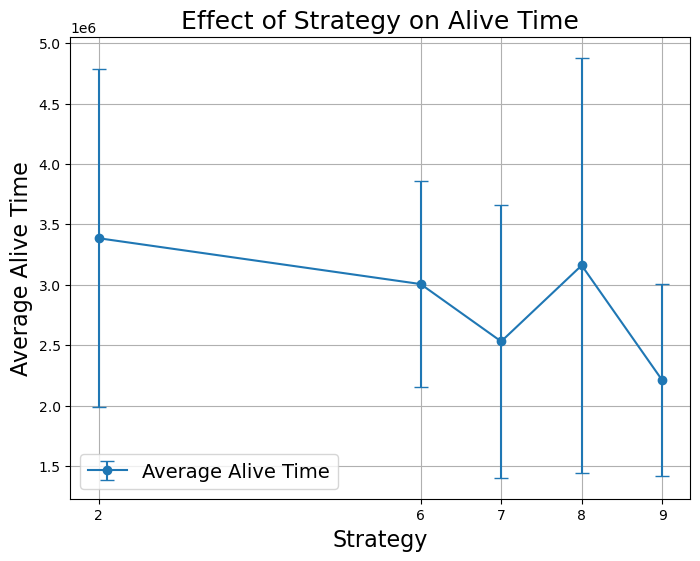

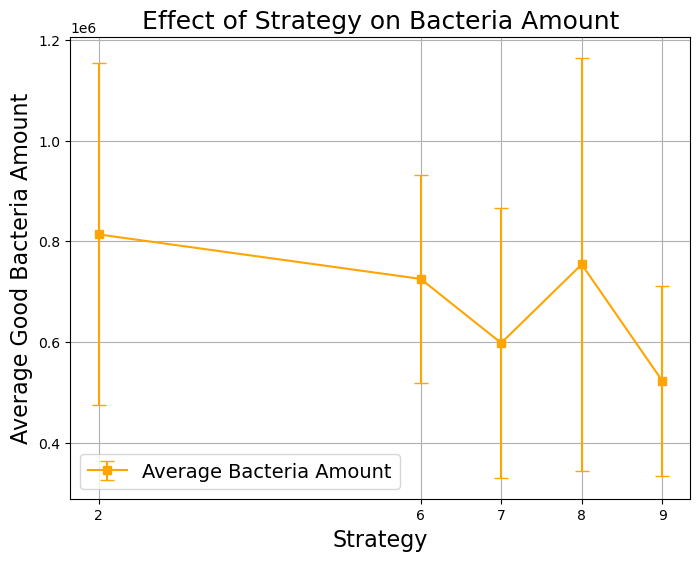

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW

# Example: For each strategy (5 strategies), provide a list of simulation outcomes.
# Replace these with your actual simulation result lists.
# Each element in alive_time_samples is a list containing simulation outcomes for that strategy.
alive_time_samples = [
    [2875618, 3991032, 3289901],
    [2891803, 2734086, 3391109],
    [2045053, 2945458, 2600976],
    [3518610, 2362471, 3600421],
    [1877456, 2234007, 2516245]
]

# Similarly, for bacteria amount at each strategy:
bacteria_amount_samples = [
    [689434, 959852, 791775],
    [696033, 661224, 818991],
    [482557, 695344, 616802],
    [839537, 564063, 859255],
    [445282, 527653, 596931]
]

# For the x-axis, e.g., strategy labels
strategies = [2,6,7,8,9]

def compute_mean_and_ci(data_lists):
    """
    For each list in data_lists, compute the mean and the half-width of the 95% confidence interval.
    Returns two lists: means and ci_errors.
    """
    means = []
    ci_errors = []
    for outcomes in data_lists:
        cs = DescrStatsW(outcomes)
        lower, upper = cs.tconfint_mean(alpha=0.05)
        mean_val = np.mean(outcomes)
        error = (upper - lower) / 2  # half-width of the confidence interval
        means.append(mean_val)
        ci_errors.append(error)
    return means, ci_errors

# Compute the mean and error for average alive time and bacteria amount
avg_alive_time, alive_time_ci = compute_mean_and_ci(alive_time_samples)
avg_bacteria_amount, bacteria_amount_ci = compute_mean_and_ci(bacteria_amount_samples)

# Plot 1: Average Alive Time vs Strategy with confidence intervals
plt.figure(figsize=(8, 6))
plt.errorbar(strategies, avg_alive_time, yerr=alive_time_ci, fmt='o-', capsize=5, label='Average Alive Time')
plt.xlabel("Strategy", fontsize=16)
plt.ylabel("Average Alive Time", fontsize=16)
plt.title("Effect of Strategy on Alive Time", fontsize=18)
plt.xticks(strategies)  # Ensure x-axis ticks match the strategy labels
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("strategy_effects_alive_time.png")
plt.show()

# Plot 2: Average Bacteria Amount vs Strategy with confidence intervals
plt.figure(figsize=(8, 6))
plt.errorbar(strategies, avg_bacteria_amount, yerr=bacteria_amount_ci, fmt='s-', capsize=5, color='orange', label='Average Bacteria Amount')
plt.xlabel("Strategy", fontsize=16)
plt.ylabel("Average Good Bacteria Amount", fontsize=16)
plt.title("Effect of Strategy on Bacteria Amount", fontsize=18)
plt.xticks(strategies)  # Ensure x-axis ticks match the strategy labels
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("strategy_effects.png")
plt.show()

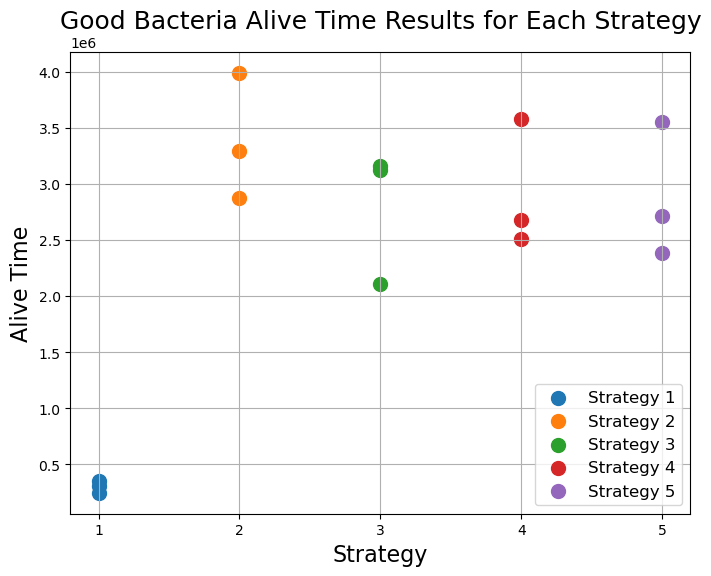

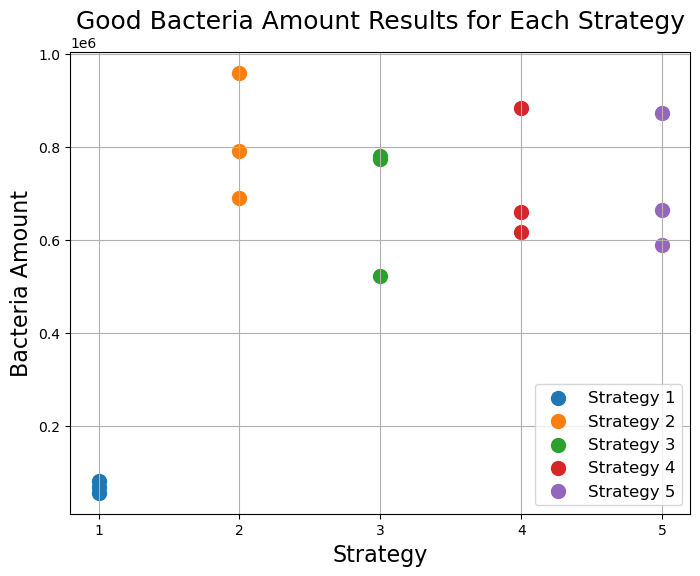

In [6]:
import matplotlib.pyplot as plt

# Example: For each strategy (5 strategies), provide a list of simulation outcomes.
# Replace these with your actual simulation result lists.
alive_time_samples = [
    [352391, 247888, 308608],
    [2875618, 3991032, 3289901],
    [3163686, 3125102, 2109553],
    [2678578, 3576173, 2505106],
    [2712073, 2387746, 3548112]
]

# Similarly, for bacteria amount at each strategy:
bacteria_amount_samples = [
    [80288, 55708, 68986],
    [689434, 959852, 791775],
    [780396, 774192, 521257],
    [659505, 884595, 616888],
    [665017, 590039, 872679]
]

# For the x-axis, e.g., strategy labels
strategies = [1, 2, 3, 4, 5]

# Plot 1: Exact Alive Time Results for Each Strategy
plt.figure(figsize=(8, 6))
for i, strategy in enumerate(strategies):
    plt.scatter([strategy] * len(alive_time_samples[i]), alive_time_samples[i], s=100, label=f"Strategy {strategy}")  # Increased marker size with `s=100`
plt.xlabel("Strategy", fontsize=16)
plt.ylabel("Alive Time", fontsize=16)
plt.title("Good Bacteria Alive Time Results for Each Strategy", fontsize=18)
plt.xticks(strategies)  # Ensure x-axis ticks match the strategy labels
plt.legend(fontsize=12, loc='lower right')
plt.grid(True)
plt.savefig("strategy_effects_alive_time.png")
plt.show()

# Plot 2: Exact Bacteria Amount Results for Each Strategy
plt.figure(figsize=(8, 6))
for i, strategy in enumerate(strategies):
    plt.scatter([strategy] * len(bacteria_amount_samples[i]), bacteria_amount_samples[i], s=100, label=f"Strategy {strategy}")  # Increased marker size with `s=100`
plt.xlabel("Strategy", fontsize=16)
plt.ylabel("Bacteria Amount", fontsize=16)
plt.title("Good Bacteria Amount Results for Each Strategy", fontsize=18)
plt.xticks(strategies)  # Ensure x-axis ticks match the strategy labels
plt.legend(fontsize=12, loc='lower right')
plt.grid(True)
plt.savefig("strategy_effects.png")
plt.show()

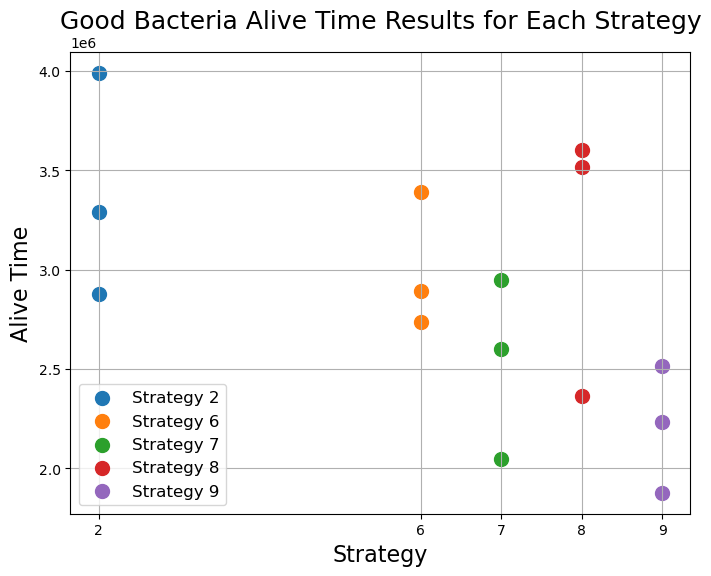

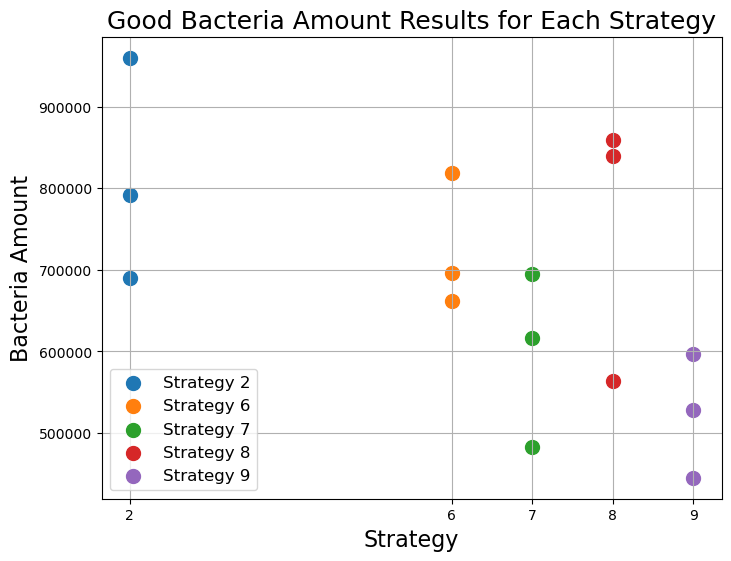

In [5]:
import matplotlib.pyplot as plt

# Example: For each strategy (5 strategies), provide a list of simulation outcomes.
# Replace these with your actual simulation result lists.
alive_time_samples = [
    [2875618, 3991032, 3289901],
    [2891803, 2734086, 3391109],
    [2045053, 2945458, 2600976],
    [3518610, 2362471, 3600421],
    [1877456, 2234007, 2516245]
]

# Similarly, for bacteria amount at each strategy:
bacteria_amount_samples = [
    [689434, 959852, 791775],
    [696033, 661224, 818991],
    [482557, 695344, 616802],
    [839537, 564063, 859255],
    [445282, 527653, 596931]
]

# For the x-axis, e.g., strategy labels
strategies = [2, 6, 7, 8, 9]

# Plot 1: Exact Alive Time Results for Each Strategy
plt.figure(figsize=(8, 6))
for i, strategy in enumerate(strategies):
    plt.scatter([strategy] * len(alive_time_samples[i]), alive_time_samples[i], s=100, label=f"Strategy {strategy}")  # Increased marker size with `s=100`
plt.xlabel("Strategy", fontsize=16)
plt.ylabel("Alive Time", fontsize=16)
plt.title("Good Bacteria Alive Time Results for Each Strategy", fontsize=18)
plt.xticks(strategies)  # Ensure x-axis ticks match the strategy labels
plt.legend(fontsize=12, loc='lower left')
plt.grid(True)
plt.savefig("strategy_effects_alive_time_2.png")
plt.show()

# Plot 2: Exact Bacteria Amount Results for Each Strategy
plt.figure(figsize=(8, 6))
for i, strategy in enumerate(strategies):
    plt.scatter([strategy] * len(bacteria_amount_samples[i]), bacteria_amount_samples[i], s=100, label=f"Strategy {strategy}")  # Increased marker size with `s=100`
plt.xlabel("Strategy", fontsize=16)
plt.ylabel("Bacteria Amount", fontsize=16)
plt.title("Good Bacteria Amount Results for Each Strategy", fontsize=18)
plt.xticks(strategies)  # Ensure x-axis ticks match the strategy labels
plt.legend(fontsize=12, loc='lower left')
plt.grid(True)
plt.savefig("strategy_effects_2.png")
plt.show()

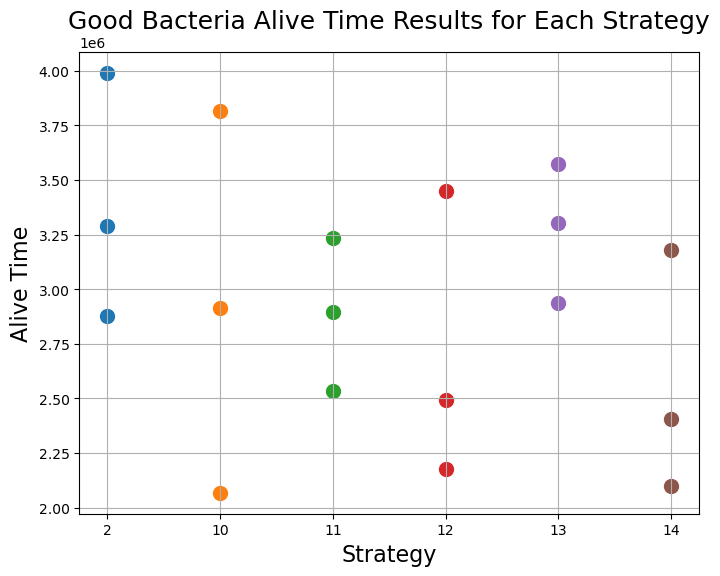

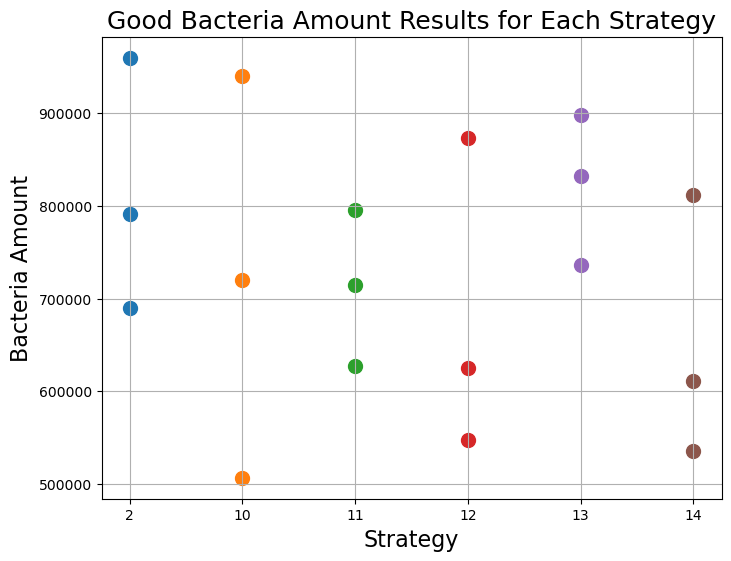

In [3]:
import matplotlib.pyplot as plt

# Example: For each strategy (6 strategies), provide a list of simulation outcomes.
# Replace these with your actual simulation result lists.
alive_time_samples = [
    [2875618, 3991032, 3289901],
    [2068483, 2914920, 3814281],
    [2894664, 3232346, 2536270],
    [2179005, 3451637, 2490771],
    [3574221, 3304975, 2935171],
    [3181138, 2097974, 2404747]
]

# Similarly, for bacteria amount at each strategy:
bacteria_amount_samples = [
    [689434, 959852, 791775],
    [506858, 719597, 939604],
    [715046, 795578, 627747],
    [547576, 872836, 624794],
    [897602, 831957, 736205],
    [811407, 535200, 611604]
]

# For the x-axis, use evenly spaced indices instead of actual strategy numbers
strategies = [1, 2, 3, 4, 5, 6]  # Evenly spaced indices

# Plot 1: Exact Alive Time Results for Each Strategy
plt.figure(figsize=(8, 6))
for i, strategy in enumerate(strategies):
    plt.scatter([strategy] * len(alive_time_samples[i]), alive_time_samples[i], s=100, label=f"Strategy {i+1}")  # Increased marker size with `s=100`
plt.xlabel("Strategy", fontsize=16)
plt.ylabel("Alive Time", fontsize=16)
plt.title("Good Bacteria Alive Time Results for Each Strategy", fontsize=18)
plt.xticks(strategies, labels=[2, 10, 11, 12, 13, 14])  # Use original strategy labels for display
plt.grid(True)
plt.savefig("strategy_effects_alive_time_adjusted.png")
plt.show()

# Plot 2: Exact Bacteria Amount Results for Each Strategy
plt.figure(figsize=(8, 6))
for i, strategy in enumerate(strategies):
    plt.scatter([strategy] * len(bacteria_amount_samples[i]), bacteria_amount_samples[i], s=100, label=f"Strategy {i+1}")  # Increased marker size with `s=100`
plt.xlabel("Strategy", fontsize=16)
plt.ylabel("Bacteria Amount", fontsize=16)
plt.title("Good Bacteria Amount Results for Each Strategy", fontsize=18)
plt.xticks(strategies, labels=[2, 10, 11, 12, 13, 14])  # Use original strategy labels for display
plt.grid(True)
plt.savefig("strategy_effects_adjusted.png")
plt.show()

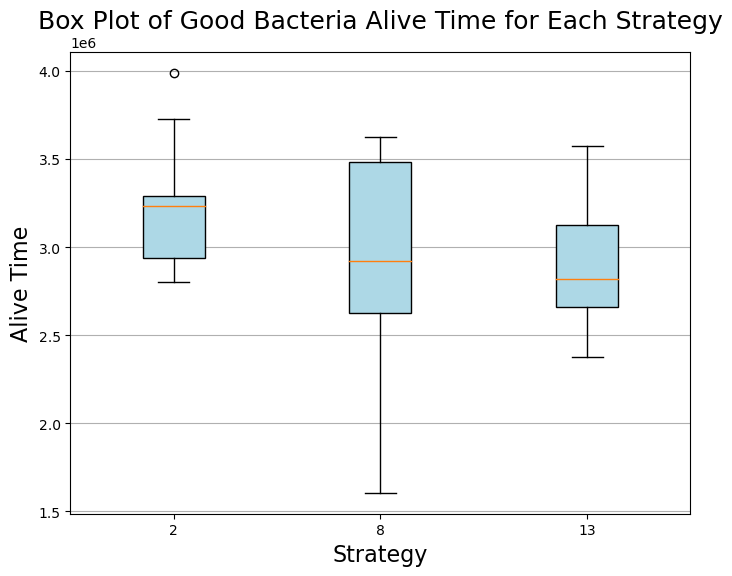

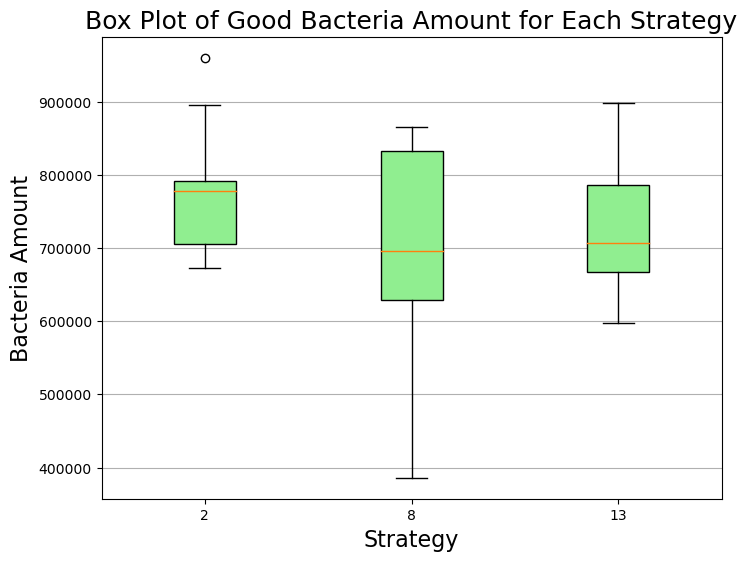

In [2]:
import matplotlib.pyplot as plt

# Example: For each strategy (3 strategies), provide a list of simulation outcomes.
# Replace these with your actual simulation result lists.
alive_time_samples = [
    [2875618, 3991032, 3289901, 3084554, 2805066, 3211016, 3726345, 3290439, 2888773, 3262332],
    [3518610, 2362471, 3600421, 2803737, 1605844, 3015551, 2568162, 3625690, 3384541, 2831738],
    [3574221, 3304975, 2935171, 2830182, 2687596, 2449218, 3192936, 2806078, 2374680, 2649449]
]

# Similarly, for bacteria amount at each strategy:
bacteria_amount_samples = [
    [689434, 959852, 791775, 740033, 672067, 772796, 894957, 789682, 693155, 783676],
    [839537, 564063, 859255, 670374, 386060, 716642, 615452, 865136, 811852, 675019],
    [897602, 831957, 736205, 708442, 675608, 612932, 803315, 704922, 596955, 663975]
]

# For the x-axis, use evenly spaced indices instead of actual strategy numbers
strategies = [2, 8, 13]  # Original strategy labels

# Plot 1: Box Plot for Alive Time
plt.figure(figsize=(8, 6))
plt.boxplot(alive_time_samples, labels=strategies, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.xlabel("Strategy", fontsize=16)
plt.ylabel("Alive Time", fontsize=16)
plt.title("Box Plot of Good Bacteria Alive Time for Each Strategy", fontsize=18)
plt.grid(axis='y')
plt.savefig("strategy_boxplot_alive_time.png")
plt.show()

# Plot 2: Box Plot for Bacteria Amount
plt.figure(figsize=(8, 6))
plt.boxplot(bacteria_amount_samples, labels=strategies, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel("Strategy", fontsize=16)
plt.ylabel("Bacteria Amount", fontsize=16)
plt.title("Box Plot of Good Bacteria Amount for Each Strategy", fontsize=18)
plt.grid(axis='y')
plt.savefig("strategy_boxplot_bacteria_amount.png")
plt.show()